# Aplicação de Modelos de Markov e Redes Neurais LSTM na Previsão de Arrecadação do ICMS Paulista
## Resultados do Experimento Univariado para a Previsão de 2014

### Antonio Sergio Ferreira Bonato

Atualmente, na Secretaria da Fazenda e Planejamento do Estado de São Paulo, a previsão de arrecadação do ICMS paulista é feita usando-se um modelo ARIMA com variáveis exógenas, o ARIMAX. Mas o ICMS é não linear e há várias quebras estruturais controladas com diversas *dummies*. A consequência é um modelo bastante sobreajustado, inadequado para previsões de mais longo prazo (mais do que alguns meses, muito menos para um ano). 
A proposta deste trabalho é utilizar modelos não lineares multivariados na previsão do ICMS paulista, utilizando redes neurais recorrentes LSTM (*Long Short Term Memory*) e modelos Markov-Switching, fazendo um contraponto entre estes dois modelos. E utilizar, como baseline de comparação, o modelo ARIMAX atual. 

**Palavras-chave**: Markov-Switching Models. Redes Neurais Recorrentes. LSTM. ICMS.

## Análise Univariada da Série de Arrecadação do ICMS Paulista 

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools
import statsmodels.tsa.x13
import statsmodels.graphics.tsaplots
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.arima.model import ARIMA
import pickle
from pmdarima.arima import auto_arima, nsdiffs, ndiffs
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import random
import tensorflow as tf
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

sns.set()
sns.set_context("notebook")
sns.set(rc={'figure.figsize':(10,7)})

In [95]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [96]:
df_main_orig = pd.read_excel("variaveis_previsao.xlsx", parse_dates=['date'])
df_main_orig.head()

,date,icms_sp,igp_m,dolar,ibc_br,dias_uteis,igp_m_22,dolar_22,ibc_br_22,igp_m_21,...,ibc_br_16,igp_m_15,dolar_15,ibc_br_15,igp_m_14,dolar_14,ibc_br_14,igp_m_13,dolar_13,ibc_br_13
0,2003-01-01,3.360296e+09,277.173,3.4384,96.15,22,277.173,3.4384,96.15,277.173,...,96.15,277.173,3.4384,96.15,277.173,3.4384,96.15,277.173,3.4384,96.15
1,2003-02-01,3.196558e+09,283.506,3.5908,98.67,20,283.506,3.5908,98.67,283.506,...,98.67,283.506,3.5908,98.67,283.506,3.5908,98.67,283.506,3.5908,98.67
2,2003-03-01,3.160011e+09,287.855,3.4469,103.41,19,287.855,3.4469,103.41,287.855,...,103.41,287.855,3.4469,103.41,287.855,3.4469,103.41,287.855,3.4469,103.41
3,2003-04-01,3.215307e+09,290.512,3.1187,102.19,20,290.512,3.1187,102.19,290.512,...,102.19,290.512,3.1187,102.19,290.512,3.1187,102.19,290.512,3.1187,102.19
4,2003-05-01,3.098930e+09,289.747,2.9557,100.30,21,289.747,2.9557,100.30,289.747,...,100.30,289.747,2.9557,100.30,289.747,2.9557,100.30,289.747,2.9557,100.30


In [97]:
df_main_orig.tail()

,date,icms_sp,igp_m,dolar,ibc_br,dias_uteis,igp_m_22,dolar_22,ibc_br_22,igp_m_21,...,ibc_br_16,igp_m_15,dolar_15,ibc_br_15,igp_m_14,dolar_14,ibc_br_14,igp_m_13,dolar_13,ibc_br_13
235,2022-08-01,1.756224e+10,1185.004,5.143287,149.60,23,1137.167829,5.6496,146.408337,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,2022-09-01,1.726287e+10,1173.793,5.236957,144.44,21,1143.597376,5.6800,142.808302,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,2022-10-01,1.565000e+10,1162.391,5.250300,142.34,20,1150.115881,5.6700,144.063428,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238,2022-11-01,1.605000e+10,1155.829,5.274650,140.80,20,1155.866460,5.6000,143.165409,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
239,2022-12-01,1.767135e+10,1161.006,5.242432,142.78,22,1161.645792,5.6000,141.405133,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
df_main_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 36 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        240 non-null    datetime64[ns]
 1   icms_sp     240 non-null    float64       
 2   igp_m       240 non-null    float64       
 3   dolar       240 non-null    float64       
 4   ibc_br      240 non-null    float64       
 5   dias_uteis  240 non-null    int64         
 6   igp_m_22    240 non-null    float64       
 7   dolar_22    240 non-null    float64       
 8   ibc_br_22   240 non-null    float64       
 9   igp_m_21    228 non-null    float64       
 10  dolar_21    228 non-null    float64       
 11  ibc_br_21   228 non-null    float64       
 12  igp_m_20    216 non-null    float64       
 13  dolar_20    216 non-null    float64       
 14  ibc_br_20   216 non-null    float64       
 15  igp_m_19    204 non-null    float64       
 16  dolar_19    204 non-null  

Removendo as linhas posteriores ao ano da previsão.

In [99]:
df_main = df_main_orig.iloc[0:144]
datas = df_main['date']

In [100]:
df_main.tail()

,date,icms_sp,igp_m,dolar,ibc_br,dias_uteis,igp_m_22,dolar_22,ibc_br_22,igp_m_21,...,ibc_br_16,igp_m_15,dolar_15,ibc_br_15,igp_m_14,dolar_14,ibc_br_14,igp_m_13,dolar_13,ibc_br_13
139,2014-08-01,9.500060e+09,546.745,2.265648,148.27,21,546.745,2.265648,148.27,546.745,...,148.27,546.745,2.265648,148.27,558.614234,2.42,153.402207,NaN,NaN,NaN
140,2014-09-01,9.796970e+09,547.839,2.332868,148.12,22,547.839,2.332868,148.12,547.839,...,148.12,547.839,2.332868,148.12,561.574889,2.44,152.235746,NaN,NaN,NaN
141,2014-10-01,1.063363e+10,549.396,2.448261,149.70,23,549.396,2.448261,149.70,549.396,...,149.70,549.396,2.448261,149.70,564.663551,2.44,154.160274,NaN,NaN,NaN
142,2014-11-01,1.015244e+10,554.769,2.548365,144.92,20,554.769,2.548365,144.92,554.769,...,144.92,554.769,2.548365,144.92,568.051533,2.45,150.594831,NaN,NaN,NaN
143,2014-12-01,1.124082e+10,558.213,2.639364,145.48,22,558.213,2.639364,145.48,558.213,...,145.48,558.213,2.639364,145.48,570.891790,2.45,150.549561,NaN,NaN,NaN


### Criação das Séries

In [101]:
icms_ts = pd.Series(list(df_main['icms_sp']), index = datas)

#### Testes de Valores Nulos

In [102]:
print('ICMS', icms_ts.isnull().sum())

ICMS 0


In [103]:
# listando os nulos do icms
icms_ts[icms_ts.isnull()]

Series([], dtype: float64)

In [104]:
# eliminando os nulos do icms
icms_ts = icms_ts[~icms_ts.isnull()]

In [105]:
icms_ts.shape

(144,)

### Plotando a Série em Nível

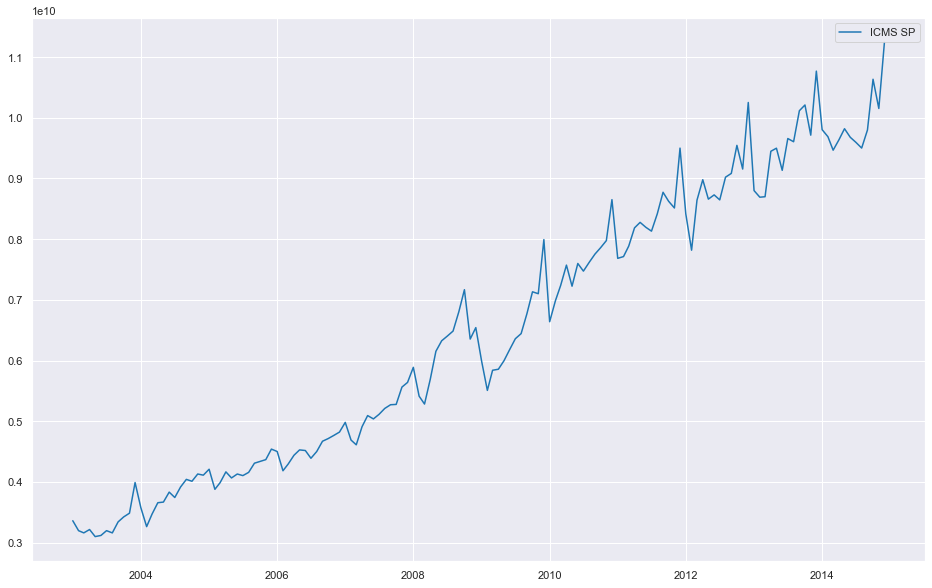

In [106]:
fig=plt.figure(figsize=(16, 10))
ax1=fig.add_subplot(111)
#plots
ax1.plot(icms_ts, 'tab:blue', label='ICMS SP')
ax1.legend(loc='best')
plt.show()

#### Últimos 24 meses da série

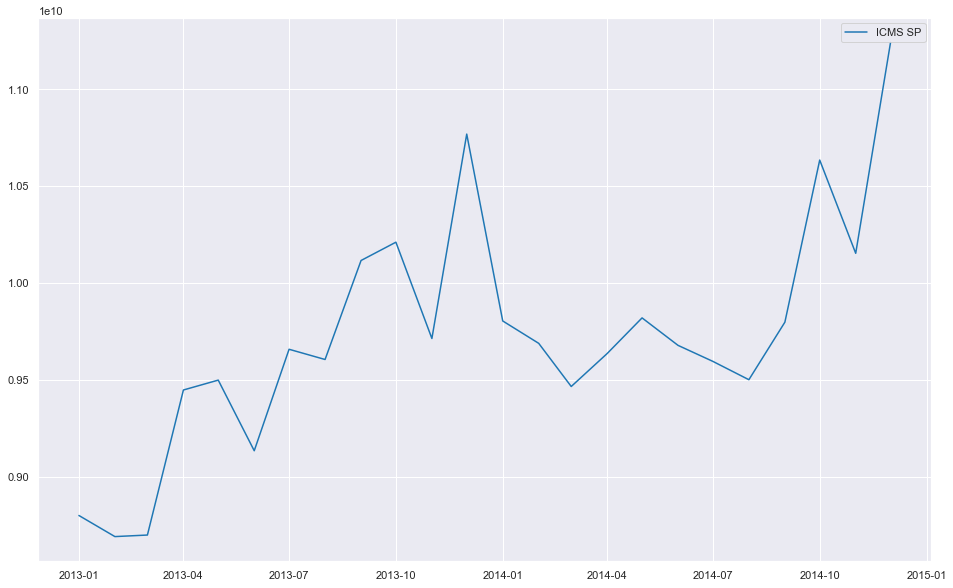

In [107]:
fig=plt.figure(figsize=(16, 10))
ax1=fig.add_subplot(111)
#plots
ax1.plot(icms_ts['2013-01-01':'2014-12-01'], 'tab:blue', label='ICMS SP')
ax1.legend(loc='best')
plt.show()

### Série em Log
Como os valores do ICMS são muito elevados a série será colocada em log.

In [108]:
l_icms_ts = pd.Series(np.log(list(df_main['icms_sp'])), index = datas)

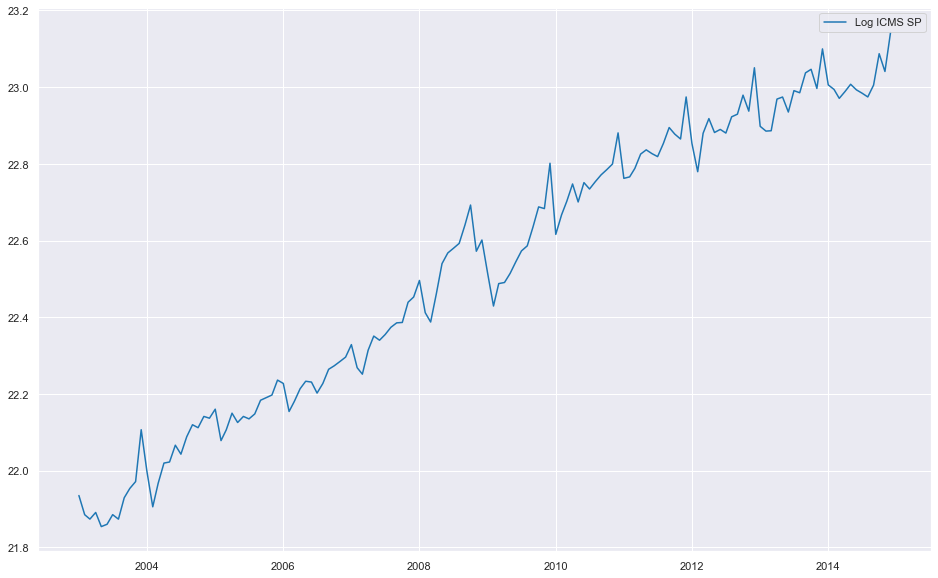

In [109]:
fig=plt.figure(figsize=(16, 10))
ax1=fig.add_subplot(111)
#plots
ax1.plot(l_icms_ts, 'tab:blue', label='Log ICMS SP')
ax1.legend(loc='best')
plt.show()

### Série em Primeira Diferença

In [110]:
icms_ts_d1 = icms_ts.diff().dropna()
l_icms_ts_d1 = l_icms_ts.diff().dropna()

### Plotando as Séries em Primeira Diferença

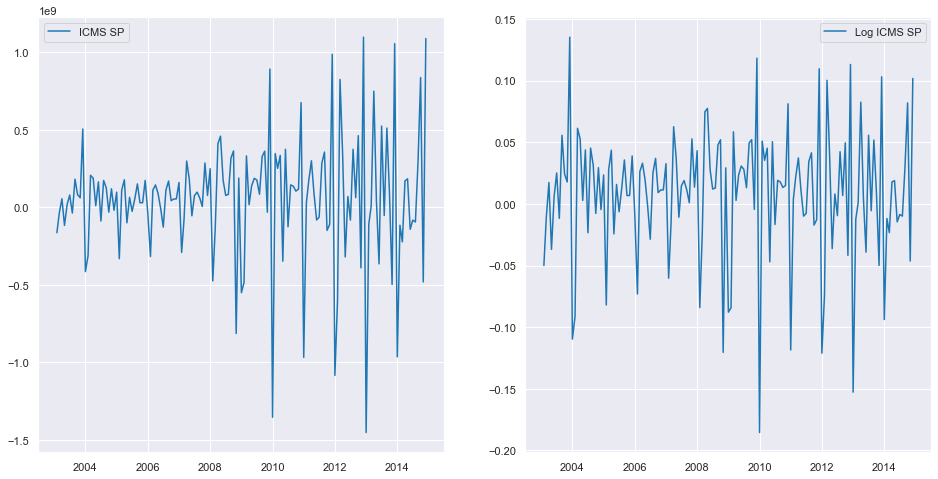

In [111]:
fig=plt.figure(figsize=(16, 8))
ax1=fig.add_subplot(121)
ax1.plot(icms_ts_d1, 'tab:blue', label='ICMS SP')
ax1.legend(loc='best')
ax2=fig.add_subplot(122)
ax2.plot(l_icms_ts_d1, 'tab:blue', label='Log ICMS SP')
ax2.legend(loc='best')
plt.show()

### Teste de Raiz Unitária da Série em Nível

Teste de raiz unitária Dickey-Fuller Aumentado (ADF): a hipótese nula é de que há raiz unitária e a série não é estacionária; a alternativa, de que não há e, portanto, a série é estacionária. 

Teste de raiz unitária Kwiatkowski-Phillips-Schmidt-Shin (KPSS): a hipótese nula é de que a série é de tendência estacionária; a alternativa é de há raiz unitária e a série não é estacionária.

A combinação dos dois testes pode ter os seguintes resultados com as seguintes consequências:

- Caso 1: Ambos os testes concluem que a série não é estacionária, então a série não é estacionária
- Caso 2: Ambos os testes concluem que a série é estacionária, então a série é estacionária
- Caso 3: o KPSS indica estacionariedade e o ADF indica não estacionariedade; a série é estacionária de tendência. A tendência precisa ser removida para tornar a série estritamente estacionária. A série sem tendência deve ser verificada quanto à estacionariedade.
- Caso 4: KPSS indica não estacionariedade e ADF indica estacionariedade; a série é estacionária diferencial. A diferenciação deve ser usada para tornar as séries estacionárias. A série diferenciada deve ser verificada quanto à estacionariedade.

**Fonte**: [Statsmodel](https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)

In [112]:
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [113]:
adf_test(l_icms_ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.858519
p-value                          0.351820
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [114]:
kpss_test(l_icms_ts)

Results of KPSS Test:
Test Statistic           1.694858
p-value                  0.010000
Lags Used                8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Série do ICMS em nível: a 5%, não rejeita-se a nula do teste ADF e rejeita-se do teste KPSS. A série não é estacionária e precisa ser posta em primeira diferença.

### Teste de Raiz Unitária da Série em Primeira Diferença
A série posta em primeira diferença será testadas para estacionariedade com os testes ADF e KPSS.

In [115]:
adf_test(l_icms_ts_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -3.579390
p-value                          0.006167
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [116]:
kpss_test(l_icms_ts_d1)

Results of KPSS Test:
Test Statistic            0.062898
p-value                   0.100000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Série do ICMS em primeira diferença: a 5%, rejeita-se a nula do teste ADF e não se rejeita a nula do teste KPSS. A série é estacionária em ambos os testes e pode se usada em primeira diferença.

In [117]:
# Estimate the number of differences using an ADF test:
n_adf = ndiffs(l_icms_ts, test='adf')  # -> 0

# Or a KPSS test (auto_arima default):
n_kpss = ndiffs(l_icms_ts, test='kpss')  # -> 0

# Or a PP test:
n_pp = ndiffs(l_icms_ts, test='pp')  # -> 0
n_adf, n_kpss, n_pp

(1, 1, 0)

### Dessazonalização da Série

In [118]:
sns.set(rc={'figure.figsize':(15,7)})

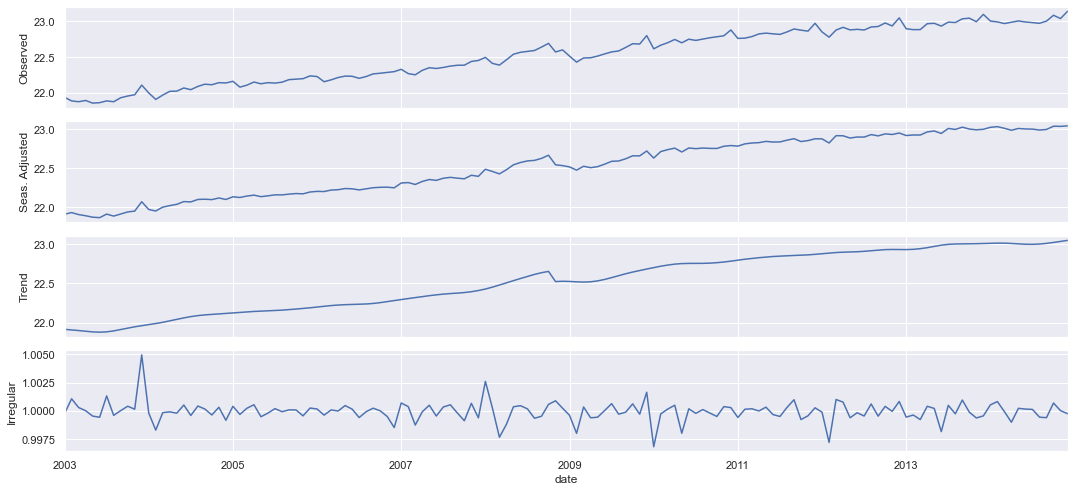

In [119]:
l_seas_icms = statsmodels.tsa.x13.x13_arima_analysis(l_icms_ts, x12path='./x13asmac/')
plot = l_seas_icms.plot()

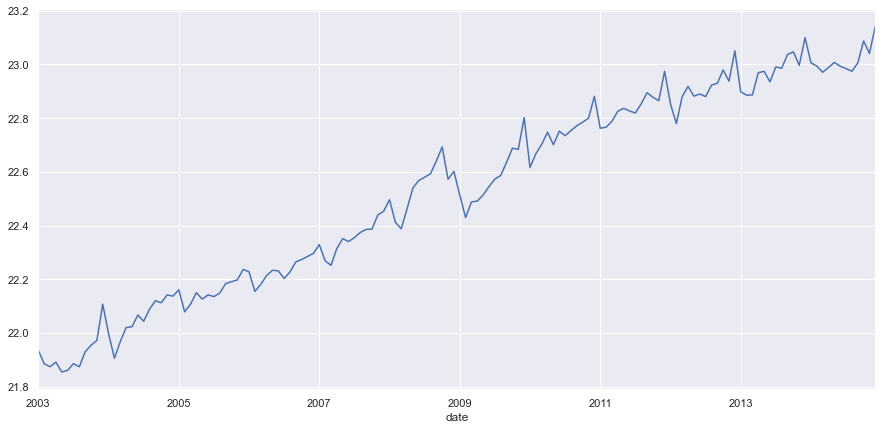

In [120]:
plot = l_seas_icms.observed.plot()

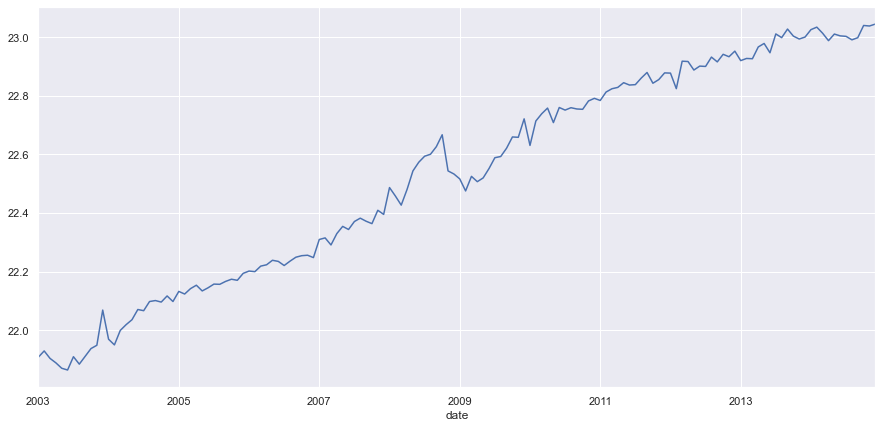

In [121]:
plot = l_seas_icms.seasadj.plot()

In [122]:
icms_decomp = pd.DataFrame(data={'ICMS observado': l_seas_icms.observed, 
                                 'ICMS desazonalizado': l_seas_icms.seasadj})

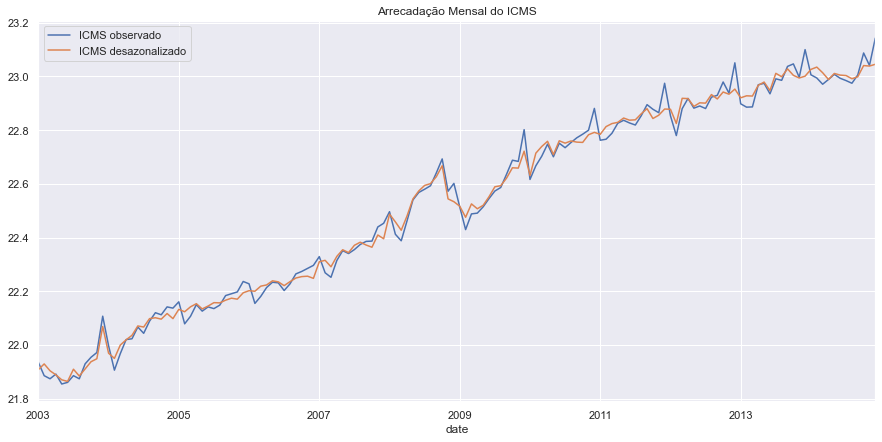

In [123]:
plot = icms_decomp.plot(title='Arrecadação Mensal do ICMS')

## Criando dummies de intervenção
Resultados do X13 Arima Seats para outliers e sazonalidade

In [124]:
pos = l_seas_icms.results.find('Outliers')
print(l_seas_icms.results[pos-309:pos+2105])

 ------------------------------------------------------------------------------
                             Parameter        Standard
 Variable                     Estimate           Error      t-value
 ------------------------------------------------------------------------------
 Automatically Identified Outliers
   AO2003.Dec                   0.0048         0.00118         4.07
   LS2008.Nov                  -0.0063         0.00117        -5.34
 ------------------------------------------------------------------------------


 ARIMA Model:  (1 1 0)(1 1 1)
   Nonseasonal differences: 1
   Seasonal differences:    1
                                              Standard
 Parameter                    Estimate          Errors
 -----------------------------------------------------
 Nonseasonal AR                                    
   Lag  1                      -0.4497         0.07269

 Seasonal AR                                       
   Lag 12                       0.4368         0.

In [125]:
ao2003dez = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
dt_final = str(ao2003dez.index[-1])

ao2003dez['2003-12-01'] = 1

ls2008nov = pd.Series(np.zeros(icms_ts.shape[0]), 
                      index=pd.date_range(start="2003-01-01", periods=icms_ts.shape[0], freq="MS"))
ls2008nov['2008-11-01':dt_final] = 1

In [126]:
ao2003dez.shape, ls2008nov.shape

((144,), (144,))

In [127]:
dummies_df = pd.DataFrame((ao2003dez, ls2008nov), 
                           index=['ao2003dez', 'ls2008nov']).transpose()
dummies_df.head()

,ao2003dez,ls2008nov
2003-01-01,0.0,0.0
2003-02-01,0.0,0.0
2003-03-01,0.0,0.0
2003-04-01,0.0,0.0
2003-05-01,0.0,0.0


In [128]:
dummies_df.tail()

,ao2003dez,ls2008nov
2014-08-01,0.0,1.0
2014-09-01,0.0,1.0
2014-10-01,0.0,1.0
2014-11-01,0.0,1.0
2014-12-01,0.0,1.0


### Teste de Raiz Unitária Sazonal

In [129]:
D = nsdiffs(icms_ts, m=12, max_D=12, test='ch')
D

0

In [130]:
D = nsdiffs(icms_ts, m=12, max_D=12, test='ocsb')
D

0

### Separando a amostra em treinamento (in-sample) e teste (out-of-sample)
Será usada a série em log, com sazonalidade e em nível. O modelo SARIMA irá lidar com a sazonalidade e a não estacionariedade. A série out-of-sample não vai estar em log para que o resultado seja real.

In [131]:
icms_train = l_icms_ts[:-12]
icms_test = icms_ts[-12:]

In [132]:
icms_train

date
2003-01-01    21.935295
2003-02-01    21.885340
2003-03-01    21.873841
2003-04-01    21.891189
2003-05-01    21.854323
                ...    
2013-08-01    22.985488
2013-09-01    23.037321
2013-10-01    23.046613
2013-11-01    22.996710
2013-12-01    23.099809
Length: 132, dtype: float64

In [133]:
icms_test

date
2014-01-01    9.803278e+09
2014-02-01    9.687760e+09
2014-03-01    9.465054e+09
2014-04-01    9.635430e+09
2014-05-01    9.819079e+09
2014-06-01    9.677264e+09
2014-07-01    9.594590e+09
2014-08-01    9.500060e+09
2014-09-01    9.796970e+09
2014-10-01    1.063363e+10
2014-11-01    1.015244e+10
2014-12-01    1.124082e+10
dtype: float64

In [134]:
dummies = dummies_df[:].to_numpy()
dummies_train = dummies[:-12]
dummies_test = dummies[-12:]
print(dummies.shape, dummies_train.shape, dummies_test.shape)
#print(dummies_train, dummies_test)

(144, 2) (132, 2) (12, 2)


## Utilidades para Previsões

Além de MAPE e MSE, será usado o erro relativo, que é 

$Erro Relativo = \frac{|previsão - real|}{real}$

In [135]:
def erro_relativo(prev, real):
    return 100*np.absolute(prev-real)/real

#### Dicionário de Previsões
Será usado para armazenar todas as previsões.

In [136]:
previsoes = {
    'nome':[],
    'modelo': [],
    'previsoes': [],
    'rmse': [],
    'mape': [],
    'erro relativo':[]
}

## Modelos Baseline
A média e a média móvel 12 meses do ano anterior (2021) serão usadas como o baseline da previsão como modelos naïve.

### Média

In [137]:
y_mean_pred = pd.Series(np.ones(12) * icms_ts[-24:-12].mean())
y_mean_pred.index = icms_test.index
y_mean_pred

date
2014-01-01    9.527815e+09
2014-02-01    9.527815e+09
2014-03-01    9.527815e+09
2014-04-01    9.527815e+09
2014-05-01    9.527815e+09
2014-06-01    9.527815e+09
2014-07-01    9.527815e+09
2014-08-01    9.527815e+09
2014-09-01    9.527815e+09
2014-10-01    9.527815e+09
2014-11-01    9.527815e+09
2014-12-01    9.527815e+09
dtype: float64

In [138]:
previsoes['nome'].append('Mean')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_mean_pred)

In [139]:
RMSE_mean = mean_squared_error(icms_test, y_mean_pred, squared=False)
previsoes['rmse'].append(RMSE_mean)
RMSE_mean

635689014.9971788

In [140]:
MAPE_mean = mean_absolute_percentage_error(icms_test, y_mean_pred)
previsoes['mape'].append(MAPE_mean)
MAPE_mean

0.038564832552040545

In [141]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_mean_pred, icms_test)])

### Comparação do modelo naïve com o real

In [142]:
prev_naive_df = pd.DataFrame(data={"Mean": previsoes['previsoes'][0]})
prev_naive_df['real'] = icms_test
prev_naive_df

,Mean,real
date,,
2014-01-01,9.527815e+09,9.803278e+09
2014-02-01,9.527815e+09,9.687760e+09
2014-03-01,9.527815e+09,9.465054e+09
2014-04-01,9.527815e+09,9.635430e+09
2014-05-01,9.527815e+09,9.819079e+09
2014-06-01,9.527815e+09,9.677264e+09
2014-07-01,9.527815e+09,9.594590e+09
2014-08-01,9.527815e+09,9.500060e+09
2014-09-01,9.527815e+09,9.796970e+09


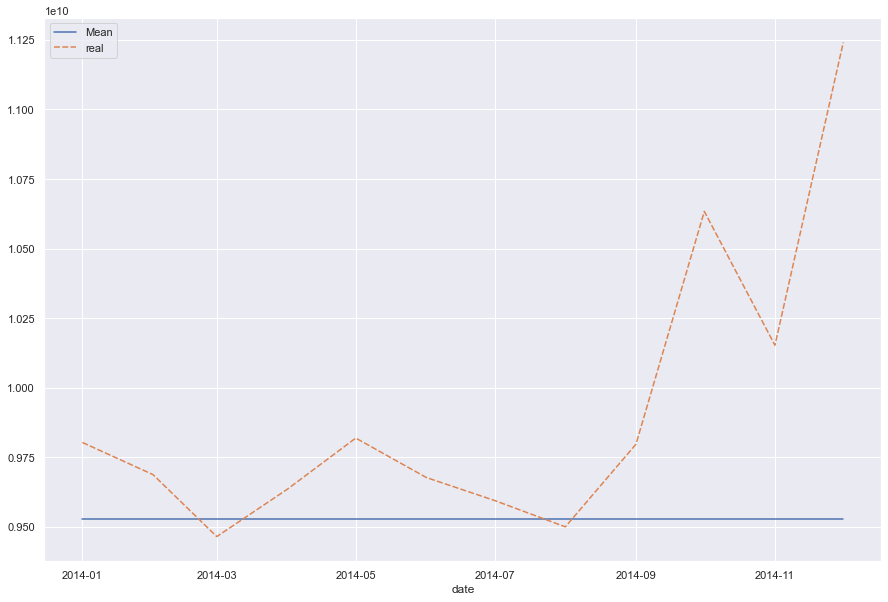

In [143]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=prev_naive_df)

## Modelos ARIMA sem Dummies de Intervenção

### Auto Arima da Série

#### Critério de Akaike

In [144]:
mod_aa_aic = auto_arima(icms_train, stationary=False, seasonal=True, m=12, 
                        information_criterion='aic', test='kpss', seasonal_test='ocsb', stepewise=True)
mod_aa_aic

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

#### Critério de Schwarz

In [145]:
mod_aa_bic = auto_arima(icms_train, stationary=False, seasonal=True, m=12,
                        information_criterion='bic', test='kpss', seasonal_test='ocsb', stepewise=True)
mod_aa_bic

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

### Modelo SARIMA(0,1,1),(1,0,1) sugerido pelo critério de Akaike e Schwarz

In [146]:
mod_arima1 = ARIMA(icms_train, order=(0,1,1), seasonal_order=(1,0,1,12))
res_arima1 = mod_arima1.fit()
print(res_arima1.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  132
Model:             ARIMA(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 236.631
Date:                          Mon, 03 Jul 2023   AIC                           -465.263
Time:                                  15:30:47   BIC                           -453.762
Sample:                              01-01-2003   HQIC                          -460.590
                                   - 12-01-2013                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4088      0.066     -6.240      0.000      -0.537      -0.280
ar.S.L12       0.9515      0.040     23.788      0.

#### Análise dos Resíduos

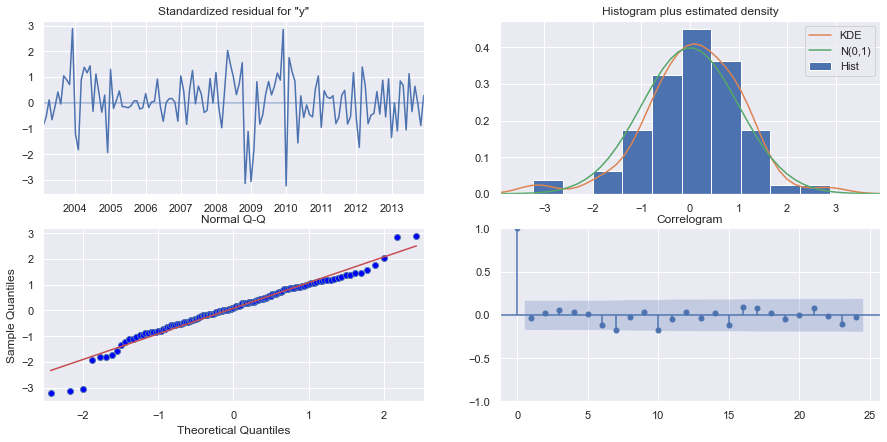

In [147]:
ax = res_arima1.plot_diagnostics(lags=24)

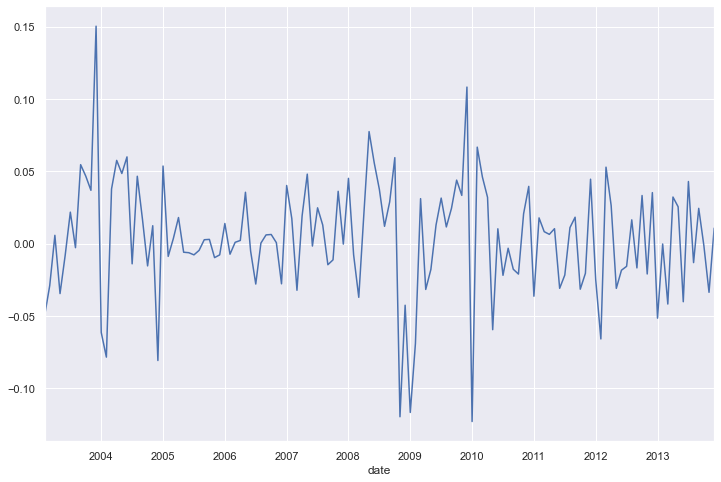

In [148]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = res_arima1.resid[1:].plot(ax=ax)

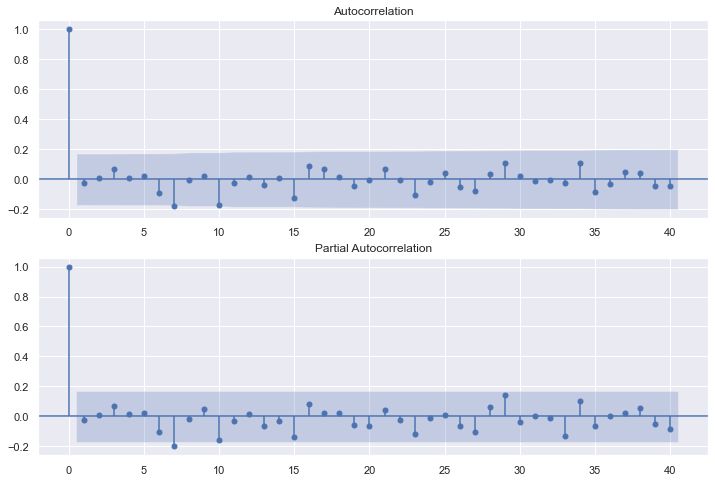

In [149]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(res_arima1.resid[1:].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(res_arima1.resid[1:], lags=40, ax=ax2)

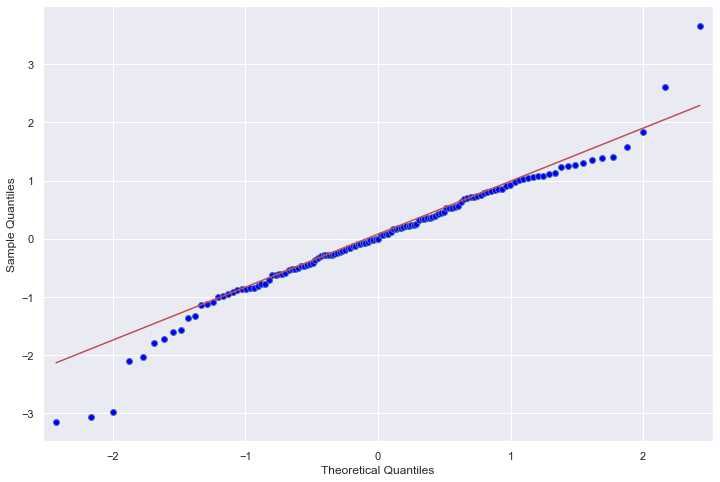

In [150]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(res_arima1.resid[1:], line="q", ax=ax, fit=True)

#### Previsões

In [151]:
previsoes['nome'].append('SARIMA(0,1,1),(1,0,1)')
previsoes['modelo'].append(res_arima1)

In [152]:
y_arima1_pred = np.exp(res_arima1.forecast(12))
previsoes['previsoes'].append(y_arima1_pred)

In [153]:
RMSE_arima1 = mean_squared_error(icms_test, y_arima1_pred, squared=False)
previsoes['rmse'].append(RMSE_arima1)
RMSE_arima1

507056199.1292657

In [154]:
MAPE_arima1 = mean_absolute_percentage_error(icms_test, y_arima1_pred)
previsoes['mape'].append(MAPE_arima1)
MAPE_arima1

0.04514699892846452

In [155]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_arima1_pred, icms_test)])

#### Comparação com o Real

In [156]:
prev_arma_df = pd.DataFrame(data={previsoes['nome'][1]: previsoes['previsoes'][1]})
prev_arma_df['real'] = icms_test
prev_arma_df

,"SARIMA(0,1,1),(1,0,1)",real
2014-01-01,9.684208e+09,9.803278e+09
2014-02-01,9.439189e+09,9.687760e+09
2014-03-01,9.711438e+09,9.465054e+09
2014-04-01,1.016781e+10,9.635430e+09
2014-05-01,1.013695e+10,9.819079e+09
2014-06-01,1.009886e+10,9.677264e+09
2014-07-01,1.023866e+10,9.594590e+09
2014-08-01,1.039424e+10,9.500060e+09
2014-09-01,1.070670e+10,9.796970e+09
2014-10-01,1.088322e+10,1.063363e+10


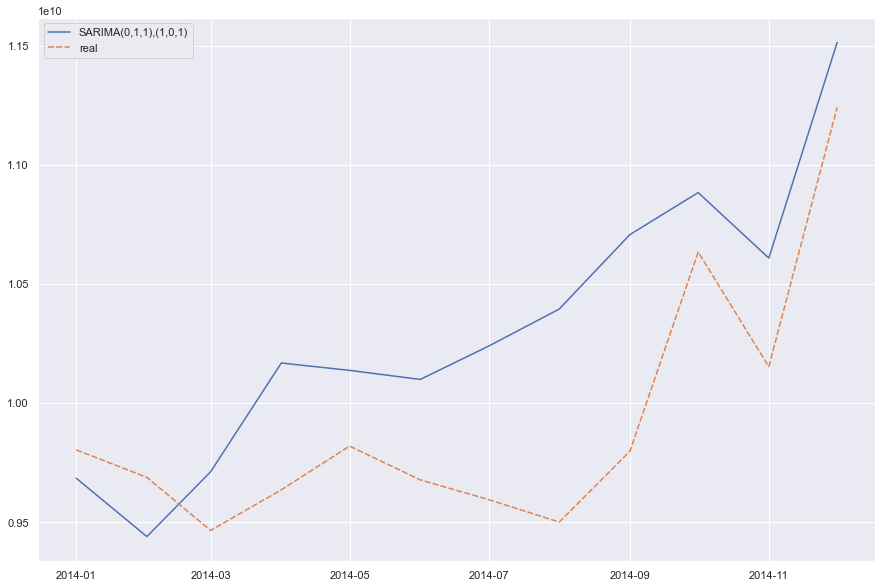

In [157]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=prev_arma_df)

## Modelos ARIMA com Dummies de Intervenção

### Auto Arima da Série

#### Critério de Akaike

In [158]:
mod_aa_aic_dum = auto_arima(icms_train, X=dummies_train, d=1, stationary=False, seasonal=True, m=12, 
                        information_criterion='aic', test='kpss', seasonal_test='ocsb', stepewise=True)
mod_aa_aic_dum

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

#### Critério de Schwarz

In [159]:
mod_aa_bic_dum = auto_arima(icms_train, x=dummies_train, d=1, stationary=False, seasonal=True, m=12, 
                        information_criterion='bic', test='kpss', seasonal_test='ocsb', stepewise=True)
mod_aa_bic_dum

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

### Modelo SARIMAX(0,1,1),(1,0,1) sugerido pelos critérios de Akaike e Schwarz
Mesmo modelo sugerido para a série sem as dummies de intervenção.

In [160]:
mod_arima3 = ARIMA(icms_train, exog=dummies_train, order=(0,1,1), seasonal_order=(1,0,1,12))
res_arima3 = mod_arima3.fit()
print(res_arima3.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  132
Model:             ARIMA(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 255.779
Date:                          Mon, 03 Jul 2023   AIC                           -499.557
Time:                                  15:31:55   BIC                           -482.306
Sample:                              01-01-2003   HQIC                          -492.547
                                   - 12-01-2013                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1278      0.063      2.041      0.041       0.005       0.251
x2            -0.1406      0.033     -4.240      0.

#### Análise dos Resíduos

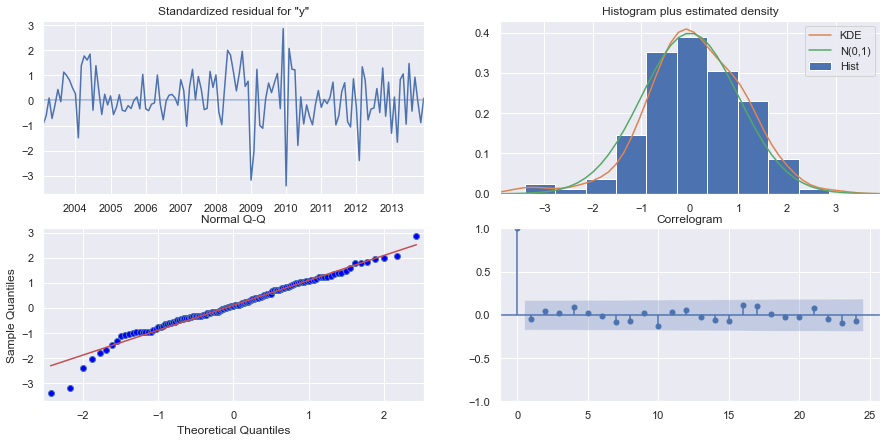

In [161]:
ax = res_arima3.plot_diagnostics(lags=24)

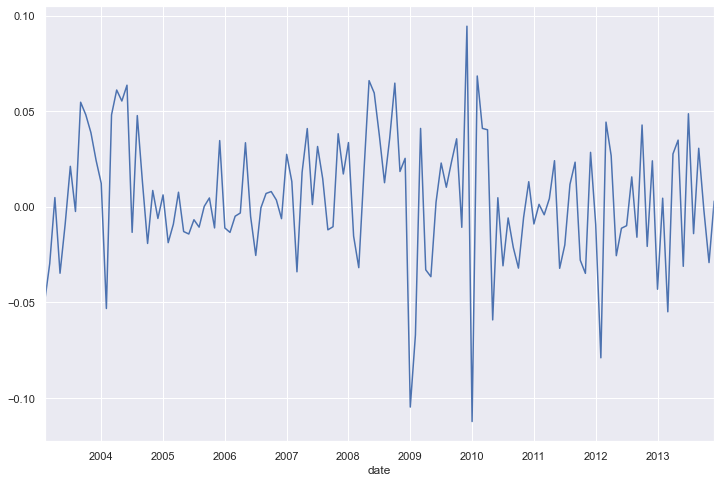

In [162]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = res_arima3.resid[1:].plot(ax=ax)

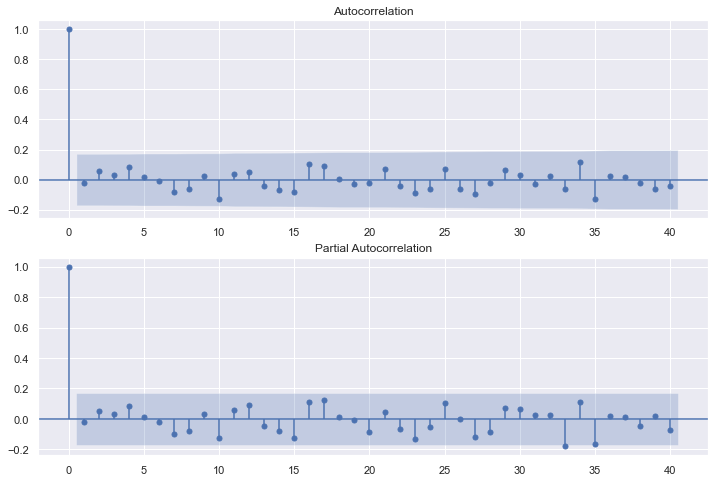

In [163]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(res_arima3.resid[1:].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(res_arima3.resid[1:], lags=40, ax=ax2)

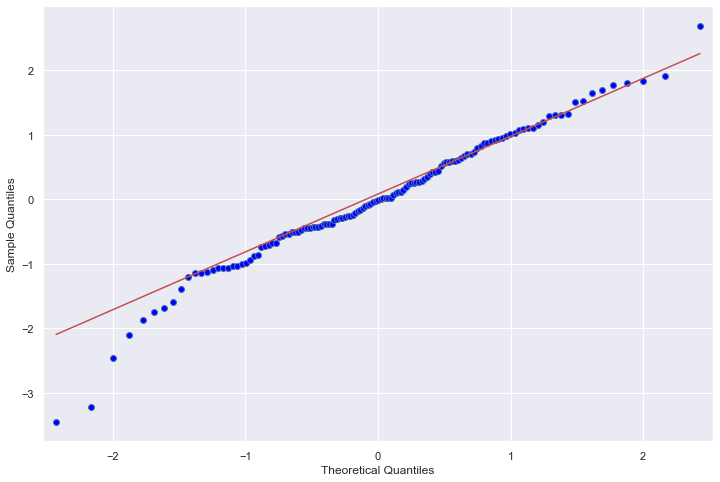

In [164]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(res_arima3.resid[1:], line="q", ax=ax, fit=True)

### Previsões

In [165]:
previsoes['nome'].append('SARIMAX(0,1,1),(1,0,1)')
previsoes['modelo'].append(res_arima3)

In [166]:
y_arima3_pred = np.exp(res_arima3.forecast(12, exog=dummies_test))
previsoes['previsoes'].append(y_arima3_pred)

In [167]:
RMSE_arima3 = mean_squared_error(icms_test, y_arima3_pred, squared=False)
previsoes['rmse'].append(RMSE_arima3)
RMSE_arima3

434745173.01082

In [168]:
MAPE_arima3 = mean_absolute_percentage_error(icms_test, y_arima3_pred)
previsoes['mape'].append(MAPE_arima3)
MAPE_arima3

0.03742300553679433

In [169]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_arima3_pred, icms_test)])

### Comparação dos modelos SARIMA

In [170]:
prev_arma_df = pd.DataFrame(data={previsoes['nome'][1]: previsoes['previsoes'][1],
                                 previsoes['nome'][2]: previsoes['previsoes'][2]})
prev_arma_df['real'] = icms_test
prev_arma_df

,"SARIMA(0,1,1),(1,0,1)","SARIMAX(0,1,1),(1,0,1)",real
2014-01-01,9.684208e+09,9.591251e+09,9.803278e+09
2014-02-01,9.439189e+09,9.398393e+09,9.687760e+09
2014-03-01,9.711438e+09,9.621435e+09,9.465054e+09
2014-04-01,1.016781e+10,1.014393e+10,9.635430e+09
2014-05-01,1.013695e+10,1.010048e+10,9.819079e+09
2014-06-01,1.009886e+10,9.936621e+09,9.677264e+09
2014-07-01,1.023866e+10,1.018630e+10,9.594590e+09
2014-08-01,1.039424e+10,1.027989e+10,9.500060e+09
2014-09-01,1.070670e+10,1.060862e+10,9.796970e+09
2014-10-01,1.088322e+10,1.076082e+10,1.063363e+10


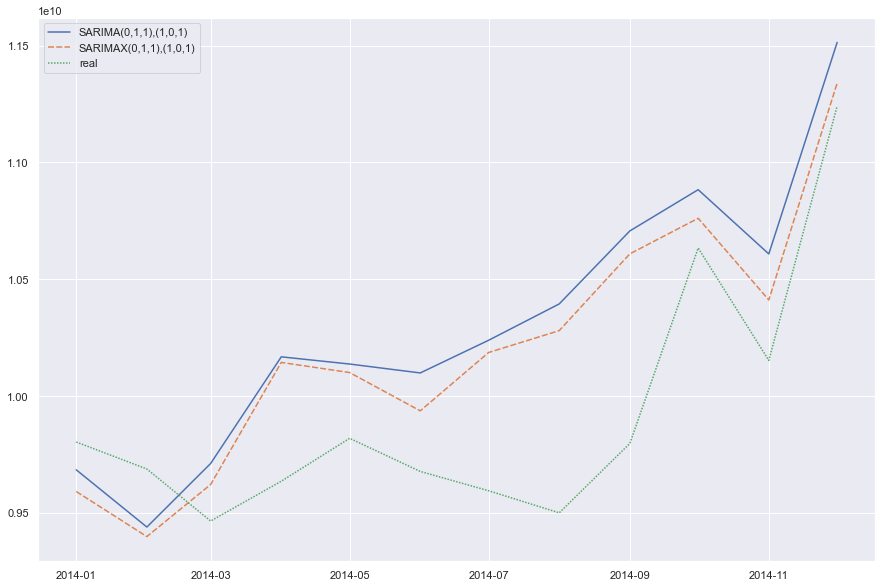

In [171]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=prev_arma_df)

## Modelo de Markov-Switching

A biblioteca statsmodel não tem implementado o método de forecast do modelo de Markov Switching. Por isso o forecast foi realizado no Ox e os dados estão sendo importados aqui.
Foram feitos 3 modelos usando as mesmas variáveis e 2 mudanças de regime:
- log icms em primeira diferença - Y
- constante - mudança de regime (*regime switching*)
- loc icms em primeira diferença com uma defasagem - (*regime switching*) 
- 11 dummies sazonais - X (variável)

E foram usados 3 tipos de variância
- variância fixa (*fixed variance*)
- mudança de variância (*switching variance*)
- componente média-variância (*mean-variance component*)

In [172]:
markov_forecast_df = pd.read_csv('forecast_markov.csv', delimiter=';', decimal=',')
markov_forecast_df = markov_forecast_df[-108:-96]
markov_forecast_df.tail()

,Unnamed: 0,date,icms_sp,igp_m,ibc_br,dias_uteis,Licms_sp,DLicms_sp,D2igp_m,Dibc_br,...,14_forecast_uni_var,13_forecast_uni_fixed,13_forecast_uni_var,13_forecast_uni_mean_var,13_forecast_multi_var,13_forecast_multi_mean_var,14_forecast_multi_fixed,14_forecast_multi_mean_var,14_forecast_multi_var,14_forecast_uni_mean_var
139,2014(8),2014-08-01,9500059699,546.745,148.27,21,22.974564,-0.009901,-4.809,-1.58,...,0.021843,NaN,NaN,NaN,NaN,NaN,0.000248,0.000953,0.000462,0.019480
140,2014(9),2014-09-01,9796970052,547.839,148.12,22,23.005339,0.030775,-0.363,-0.15,...,0.037151,NaN,NaN,NaN,NaN,NaN,0.054083,0.056195,0.054856,0.035215
141,2014(10),2014-10-01,10633628202,549.396,149.70,23,23.087287,0.081948,2.651,1.58,...,0.015127,NaN,NaN,NaN,NaN,NaN,0.026830,0.025474,0.029378,0.015524
142,2014(11),2014-11-01,10152442435,554.769,144.92,20,23.040980,-0.046307,6.930,-4.78,...,-0.005555,NaN,NaN,NaN,NaN,NaN,-0.015214,-0.012940,-0.012908,-0.001955
143,2014(12),2014-12-01,11240824439,558.213,145.48,22,23.142818,0.101838,8.817,0.56,...,0.080705,NaN,NaN,NaN,NaN,NaN,0.086109,0.063841,0.119945,0.102165


### Variância Fixa

In [173]:
arq1 = open('./ox/14_results_uni_fixed.txt', 'r')
print(arq1.read())
arq1.close()


Switching(33) Modelling DLicms_sp by MS(2)
              The dataset is: /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/final/ox/variaveis_previsao.xlsx
              The estimation sample is: 2003-04-01 - 2013-12-01

                 Coefficient   Std.Error  t-value  t-prob
CSeasonal         -0.0953056     0.01378    -6.92   0.000
CSeasonal_1        -0.139626     0.01441    -9.69   0.000
CSeasonal_2       -0.0657268     0.01323    -4.97   0.000
CSeasonal_3       -0.0226735     0.01322    -1.71   0.089
CSeasonal_4       -0.0565502     0.01418    -3.99   0.000
CSeasonal_5       -0.0584182     0.01258    -4.64   0.000
CSeasonal_6       -0.0593630     0.01274    -4.66   0.000
CSeasonal_7       -0.0525943     0.01282    -4.10   0.000
CSeasonal_8       -0.0295281     0.01292    -2.29   0.024
CSeasonal_9       -0.0436631     0.01348    -3.24   0.002
CSeasonal_10      -0.0682677     0.01238    -5.51   0.000
Constant(0)        0.0211927    0.004370     4.85   0.000
Constant(1)       0.00904

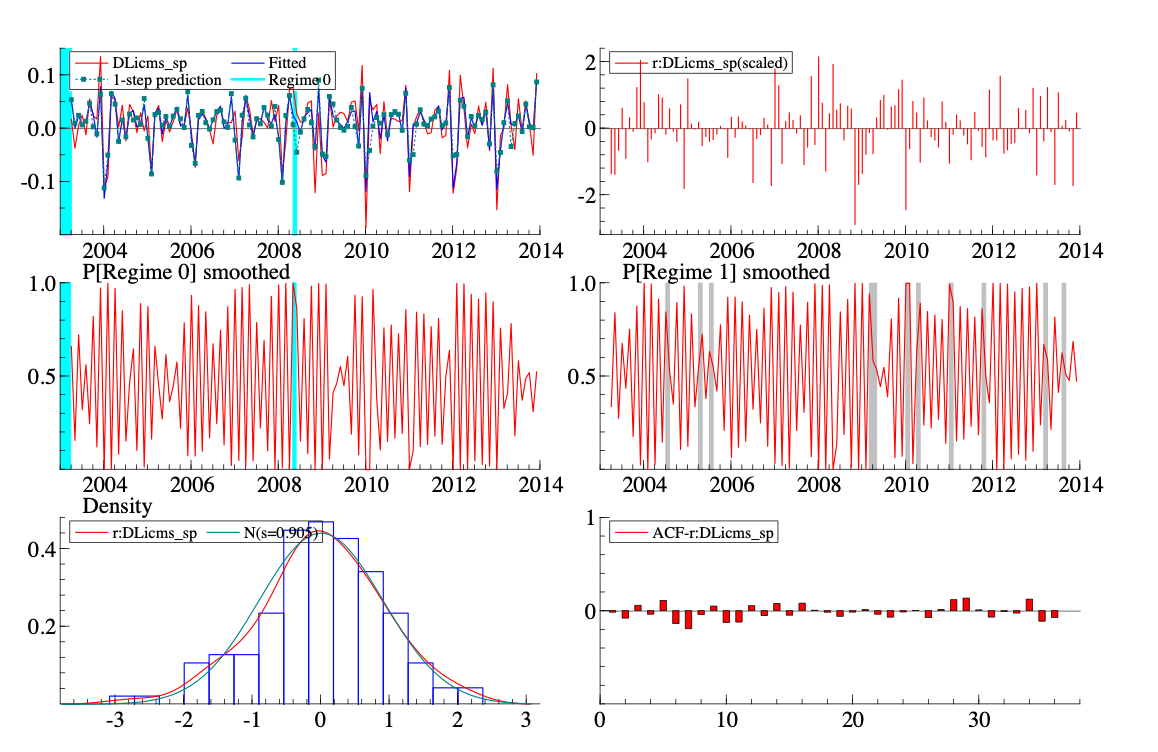

#### Previsões

In [174]:
y_markov_fixed_pred = np.exp(np.cumsum(markov_forecast_df['14_forecast_uni_fixed'])+icms_train[-1])
y_markov_fixed_pred.index = icms_test.index
y_markov_fixed_pred

date
2014-01-01    1.007163e+10
2014-02-01    9.652935e+09
2014-03-01    9.883833e+09
2014-04-01    1.029767e+10
2014-05-01    1.029120e+10
2014-06-01    1.043959e+10
2014-07-01    1.051623e+10
2014-08-01    1.069690e+10
2014-09-01    1.109071e+10
2014-10-01    1.125571e+10
2014-11-01    1.123702e+10
2014-12-01    1.208862e+10
Name: 14_forecast_uni_fixed, dtype: float64

In [175]:
previsoes['nome'].append('Markov-Fixed')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_fixed_pred)

In [176]:
RMSE_markov_fixed = mean_squared_error(icms_test, y_markov_fixed_pred, squared=False)
previsoes['rmse'].append(RMSE_markov_fixed)
RMSE_markov_fixed

802542357.536113

In [177]:
MAPE_markov_fixed = mean_absolute_percentage_error(icms_test, y_markov_fixed_pred)
previsoes['mape'].append(MAPE_markov_fixed)
MAPE_markov_fixed

0.07213739783491553

In [178]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_fixed_pred, icms_test)])

### Modelo com Mudança de Variância

In [179]:
arq2 = open('./ox/14_results_uni_var.txt', 'r')
print(arq2.read())
arq2.close()


Switching(34) Modelling DLicms_sp by MS(2)
              The dataset is: /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/final/ox/variaveis_previsao.xlsx
              The estimation sample is: 2003-04-01 - 2013-12-01

                 Coefficient   Std.Error  t-value  t-prob
CSeasonal          -0.139007     0.01838    -7.56   0.000
CSeasonal_1        -0.154305     0.01444    -10.7   0.000
CSeasonal_2       -0.0735960     0.01424    -5.17   0.000
CSeasonal_3       -0.0208545     0.01490    -1.40   0.164
CSeasonal_4       -0.0566855     0.01554    -3.65   0.000
CSeasonal_5       -0.0690464     0.01404    -4.92   0.000
CSeasonal_6       -0.0729276     0.01488    -4.90   0.000
CSeasonal_7       -0.0558517     0.01263    -4.42   0.000
CSeasonal_8       -0.0319798     0.01325    -2.41   0.017
CSeasonal_9       -0.0475550     0.01461    -3.26   0.002
CSeasonal_10      -0.0775356     0.01565    -4.95   0.000
Constant(0)       0.00965435    0.003525     2.74   0.007
Constant(1)        0.0135

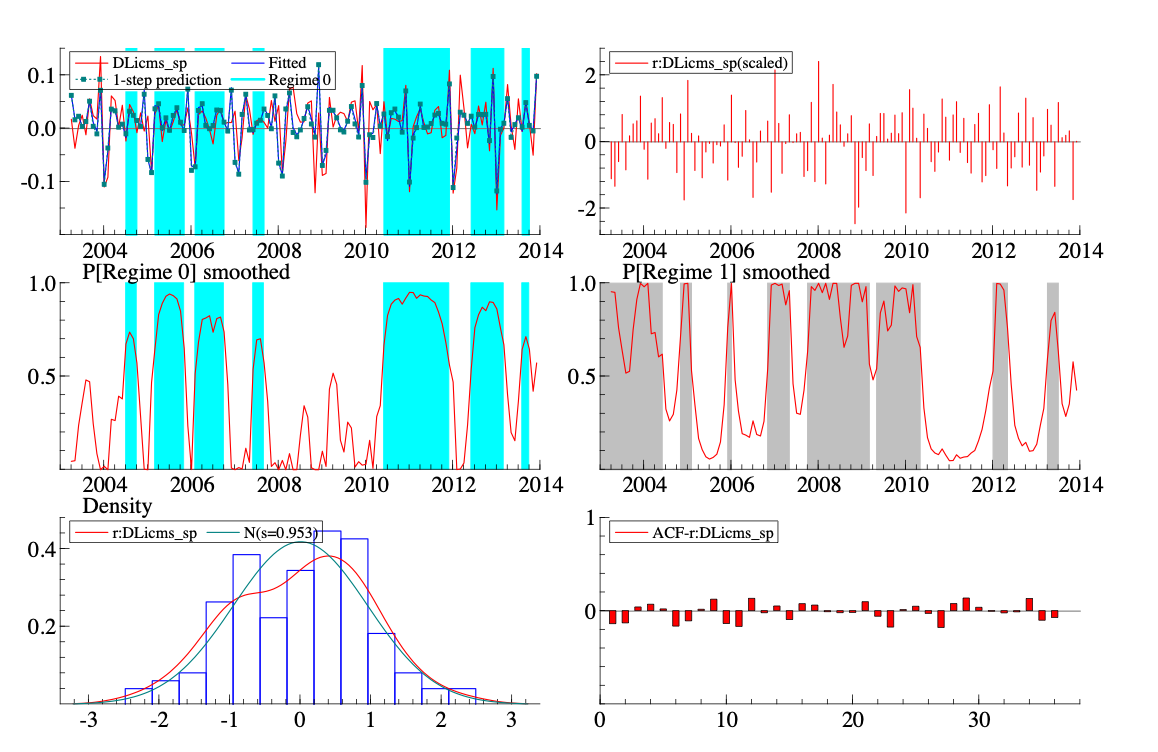

#### Previsões

In [180]:
y_markov_var_pred = np.exp(np.cumsum(markov_forecast_df['14_forecast_uni_var'])+icms_train[-1])
y_markov_var_pred.index = icms_test.index
y_markov_var_pred

date
2014-01-01    9.678321e+09
2014-02-01    9.395793e+09
2014-03-01    9.560822e+09
2014-04-01    1.005072e+10
2014-05-01    1.005418e+10
2014-06-01    1.014643e+10
2014-07-01    1.016212e+10
2014-08-01    1.038654e+10
2014-09-01    1.077967e+10
2014-10-01    1.094398e+10
2014-11-01    1.088335e+10
2014-12-01    1.179811e+10
Name: 14_forecast_uni_var, dtype: float64

In [181]:
previsoes['nome'].append('Markov-Switching-Var')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_var_pred)

In [182]:
RMSE_markov_var = mean_squared_error(icms_test, y_markov_var_pred, squared=False)
previsoes['rmse'].append(RMSE_markov_var)
RMSE_markov_var

545637736.5199159

In [183]:
MAPE_markov_var = mean_absolute_percentage_error(icms_test, y_markov_var_pred)
previsoes['mape'].append(MAPE_markov_var)
MAPE_markov_var

0.04767124075004495

In [184]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_var_pred, icms_test)])

### Componente Média-Variância

In [185]:
arq3 = open('./ox/14_results_uni_mean_var.txt', 'r')
print(arq3.read())
arq3.close()


Switching( 5) Modelling DLicms_sp by MS_Component(2, 2)
              The dataset is: /Users/asbonato/mpe-fgv-eesp/_dissertacao/codigo/final/ox/variaveis_previsao.xlsx
              The estimation sample is: 2003-03-01 - 2013-12-01

                 Coefficient   Std.Error  t-value  t-prob
CSeasonal          -0.193233     0.02210    -8.74   0.000
CSeasonal_1        -0.179774     0.01496    -12.0   0.000
CSeasonal_2       -0.0888018     0.01550    -5.73   0.000
CSeasonal_3       -0.0518599     0.01431    -3.62   0.000
CSeasonal_4       -0.0953563     0.01456    -6.55   0.000
CSeasonal_5       -0.0912545     0.01299    -7.03   0.000
CSeasonal_6       -0.0957650     0.01319    -7.26   0.000
CSeasonal_7       -0.0814353     0.01302    -6.26   0.000
CSeasonal_8       -0.0610060     0.01334    -4.57   0.000
CSeasonal_9       -0.0763329     0.01399    -5.46   0.000
CSeasonal_10      -0.0992727     0.01401    -7.09   0.000
Constant(0)       0.00678053    0.004862     1.39   0.166
Constant(1) 

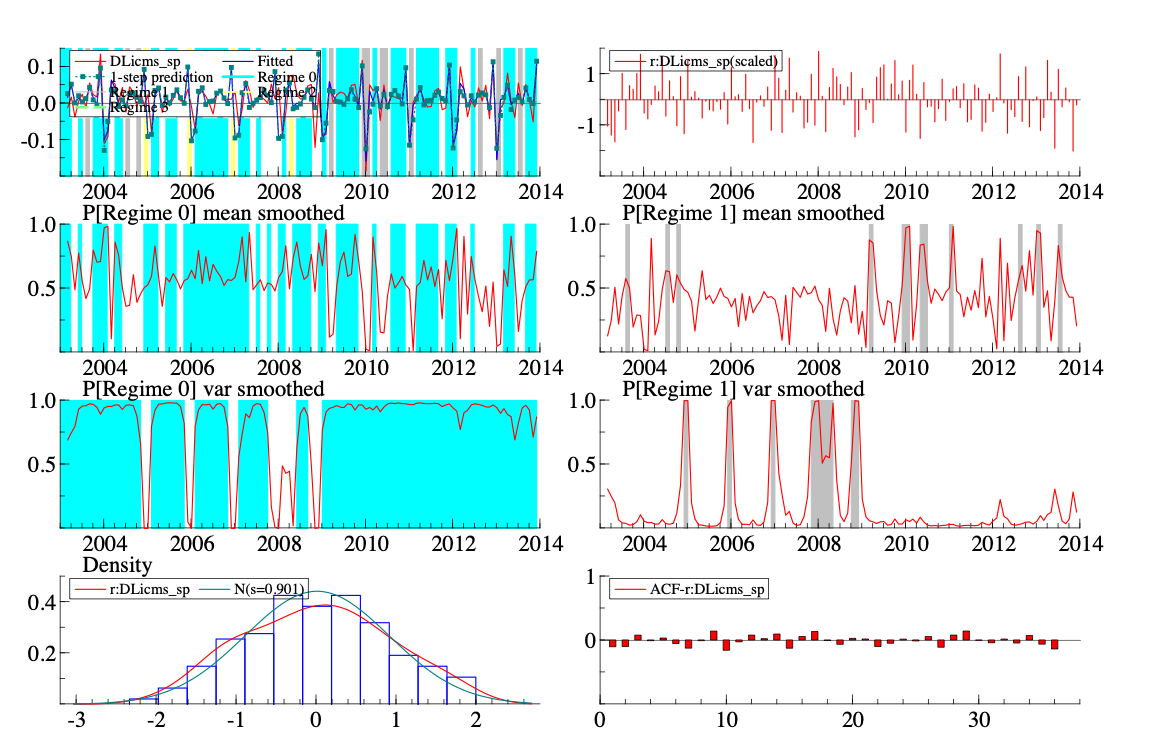

#### Previsões

In [186]:
y_markov_mean_var_pred = np.exp(np.cumsum(markov_forecast_df['14_forecast_uni_mean_var'])+icms_train[-1])
y_markov_mean_var_pred.index = icms_test.index
y_markov_mean_var_pred

date
2014-01-01    9.554910e+09
2014-02-01    9.133837e+09
2014-03-01    9.368052e+09
2014-04-01    9.777133e+09
2014-05-01    9.722660e+09
2014-06-01    9.839228e+09
2014-07-01    9.864376e+09
2014-08-01    1.005842e+10
2014-09-01    1.041893e+10
2014-10-01    1.058193e+10
2014-11-01    1.056126e+10
2014-12-01    1.169730e+10
Name: 14_forecast_uni_mean_var, dtype: float64

In [187]:
previsoes['nome'].append('Markov-Mean-Var')
previsoes['modelo'].append(None)
previsoes['previsoes'].append(y_markov_mean_var_pred)

In [188]:
RMSE_markov_mean_var = mean_squared_error(icms_test, y_markov_mean_var_pred, squared=False)
previsoes['rmse'].append(RMSE_markov_mean_var)
RMSE_markov_mean_var

363213754.7949033

In [189]:
MAPE_markov_mean_var = mean_absolute_percentage_error(icms_test, y_markov_mean_var_pred)
previsoes['mape'].append(MAPE_markov_mean_var)
MAPE_markov_mean_var

0.03084498017429323

In [190]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(y_markov_mean_var_pred, icms_test)])

#### Resultados dos Modelos de Markov

In [191]:
previsoes['nome']

['Mean',
 'SARIMA(0,1,1),(1,0,1)',
 'SARIMAX(0,1,1),(1,0,1)',
 'Markov-Fixed',
 'Markov-Switching-Var',
 'Markov-Mean-Var']

In [192]:
prev_markov_df = pd.DataFrame(data={previsoes['nome'][3]: previsoes['previsoes'][3],
                                    previsoes['nome'][4]: previsoes['previsoes'][4],
                                    previsoes['nome'][5]: previsoes['previsoes'][5]
                                   })
prev_markov_df['real'] = icms_test
prev_markov_df

,Markov-Fixed,Markov-Switching-Var,Markov-Mean-Var,real
date,,,,
2014-01-01,1.007163e+10,9.678321e+09,9.554910e+09,9.803278e+09
2014-02-01,9.652935e+09,9.395793e+09,9.133837e+09,9.687760e+09
2014-03-01,9.883833e+09,9.560822e+09,9.368052e+09,9.465054e+09
2014-04-01,1.029767e+10,1.005072e+10,9.777133e+09,9.635430e+09
2014-05-01,1.029120e+10,1.005418e+10,9.722660e+09,9.819079e+09
2014-06-01,1.043959e+10,1.014643e+10,9.839228e+09,9.677264e+09
2014-07-01,1.051623e+10,1.016212e+10,9.864376e+09,9.594590e+09
2014-08-01,1.069690e+10,1.038654e+10,1.005842e+10,9.500060e+09
2014-09-01,1.109071e+10,1.077967e+10,1.041893e+10,9.796970e+09


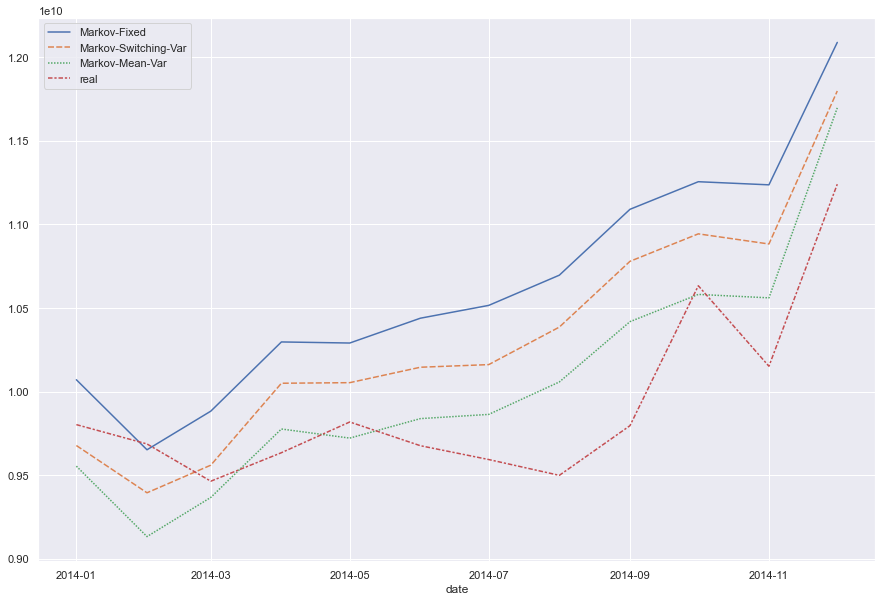

In [193]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=prev_markov_df)

## Modelos RNN LSTM
Redes Neurais Recorrentes com neurônios Long Short-Term Memory

### Montagem da Série
As redes neurais precisam de conjuntos de características e de etiquetas separados. Neste caso, o conjunto de etiquetas é a própria série de ICMS. Para os conjunto de caraterísticas será utilizada a série do ICMS com lags 1, 2, 3, 4, 6 e 12 defasagens, e médias móveis de 2, 3, 6 e 12 meses, conforme trabalho de [Silva & Figueiredo, 2020].

In [194]:
def cria_features_target(serie, verbose=0):
    serie_d1 = serie.shift(1)
    serie_d2 = serie.shift(2)
    serie_d3 = serie.shift(3)
    serie_d4 = serie.shift(4)
    serie_d6 = serie.shift(6)
    serie_d12 = serie.shift(12)
    serie_ma2 = serie.rolling(2).mean()
    serie_ma3 = serie.rolling(3).mean()
    serie_ma6 = serie.rolling(6).mean()
    serie_ma12 = serie.rolling(12).mean()

    if verbose==1:
        print("shape de cada uma das séries:")
        print(serie_d1.shape, serie_d2.shape, serie_d3.shape, serie_d4.shape, 
              serie_d6.shape, serie_d12.shape, serie_ma2.shape, serie_ma3.shape, 
              serie_ma6.shape, serie_ma12.shape)
    X = np.array([serie_d1, serie_d2, serie_d3, serie_d4, 
     serie_d6, serie_d12, serie_ma2, serie_ma3, 
     serie_ma6, serie_ma12])
    if verbose==1:
        print("shape do array de features:", X.shape)
    X = X[:,12:]
    X = X.T
    if verbose==1:
        print("shape do array de features depois da poda e da transposição:", X.shape)
    Y = np.array(serie[12:])
    if verbose==1:
        print("shape do array target:", Y.shape)
    return X, Y

In [195]:
#série completa, com sazonalidade e em nível
#seas_icms_ts = seas_icms.seasadj
X_data, Y_data = cria_features_target(l_icms_ts, verbose=1)

shape de cada uma das séries:
(144,) (144,) (144,) (144,) (144,) (144,) (144,) (144,) (144,) (144,)
shape do array de features: (10, 144)
shape do array de features depois da poda e da transposição: (132, 10)
shape do array target: (132,)


In [196]:
#print(X_data[0])
#print(Y_data[0])
#print(X_data[X_data.shape[0]-1])
#print(Y_data[X_data.shape[0]-1])

#### Normalização dos Dados
Serão normalizados usando-se min-max. Apenas as features, a variável target não será normalizada. Os dados serão dividos em treno, validação e teste para a normalização, de modo que o fit seja feito somente nos dados de treino, aumentando-se assim a probabilidade de generalização do modelo.

In [197]:
X_train = X_data[:-24]
X_val = X_data[-24:-12]
X_test = X_data[-12:]
print(X_train.shape, X_val.shape, X_test.shape)
#Y_train = Y_data[:-24]
#Y_val = Y_data[-24:-12]
#Y_test = Y_data[-12:]
#print(Y_train.shape, Y_val.shape, Y_test.shape)

(108, 10) (12, 10) (12, 10)


In [198]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
# índice dos atributos numéricos
num_atrib = list(range(10))
print('numéricas', num_atrib)

enc_x = ColumnTransformer([('min-max',MinMaxScaler(), num_atrib)], verbose=True)

print(enc_x)
X_train_std = enc_x.fit_transform(X_train)
X_val_std = enc_x.transform(X_val)
X_test_std = enc_x.transform(X_test)

print(X_train_std.shape)
print(X_val_std.shape)
print(X_test_std.shape)

#enc_y = MinMaxScaler()

#print(enc_y)
#Y_train_std = enc_y.fit_transform(Y_train.reshape(Y_train.shape[0], 1))
#Y_val_std = enc_y.transform(Y_val.reshape(12,1))
#Y_test_std = enc_y.transform(Y_test.reshape(12,1))

#print(Y_train_std.shape)
#print(Y_val_std.shape)
#print(Y_test_std.shape)

numéricas [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ColumnTransformer(transformers=[('min-max', MinMaxScaler(),
                                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])],
                  verbose=True)
[ColumnTransformer] ....... (1 of 1) Processing min-max, total=   0.0s
(108, 10)
(12, 10)
(12, 10)


### Modelo 1 mês
Neste modelo cada mês será previsto pelos dados do mês anterior

#### Criando as janelas de 12 meses e reshape para LSTM. A arrecadação de cada mês será prevista pela arrecadação dos 12 meses anteriores.

In [199]:
X_data_jn = np.concatenate((X_train_std, X_val_std, X_test_std), axis = 0)
X_data_jn = X_data_jn.reshape(X_data_jn.shape[0],10,1)
print(X_data_jn.shape)

(132, 10, 1)


In [200]:
def janelamento_1_mes(X, Y, verbose=0):
    X_exp = np.roll(X, 1, axis=0)
    X_exp_cut = X_exp[1:,:,:]#.transpose(0,2,1)
    Y_cut = Y[1:]
    if verbose==1:
        print('shape das features janeladas:', X_exp.shape)
        print('shape das features janeladas pós poda e transposição:', X_exp_cut.shape)
        print('shape do array target pós poda:', Y_cut.shape)
    return X_exp_cut, Y_cut

In [201]:
X_data_exp_cut1, Y_data_cut1 = janelamento_1_mes(X_data_jn, Y_data, verbose=0)

In [202]:
X_data_exp_cut1.shape, Y_data_cut1.shape

((131, 10, 1), (131,))

In [203]:
X_data_exp_cut1[0]

array([[0.18728272],
       [0.06125638],
       [0.04487487],
       [0.02209274],
       [0.01061837],
       [0.07228595],
       [0.10923804],
       [0.06633062],
       [0.        ],
       [0.        ]])

In [204]:
Y_data_cut1[0]

21.905893928886627

In [205]:
Y_data_cut1[Y_data_cut1.shape[0]-1]

23.14281802739823

In [206]:
X_data_exp_cut1[Y_data_cut1.shape[0]-1]

array([[1.10068053],
       [1.02433095],
       [1.00007364],
       [1.0093394 ],
       [1.0300781 ],
       [1.0198406 ],
       [1.06625406],
       [1.05367918],
       [1.06571539],
       [1.10575567]])

#### Separando novamente em treino, validação e teste

In [207]:
x_train1 = X_data_exp_cut1[:-24]
x_val1 = X_data_exp_cut1[-24:-12]
x_test1 = X_data_exp_cut1[-12:]
print(x_train1.shape, x_val1.shape, x_test1.shape)
y_train1 = Y_data_cut1[:-24]
y_val1 = Y_data_cut1[-24:-12]
y_test1 = Y_data_cut1[-12:]
print(y_train1.shape, y_val1.shape, y_test1.shape)

(107, 10, 1) (12, 10, 1) (12, 10, 1)
(107,) (12,) (12,)


### Criando o modelo LSTM

In [208]:
# importando as bibliotecas do Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [209]:
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=25, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=100, verbose=1, 
                           restore_best_weights=True)

#### Arquitetura da Rede

In [210]:
# Hiperparâmetros
EPOCHS = 1000
BATCH = 8
NEURONIOS = 600
LR = 1e-5
DROPOUT = 0.25

# Imstanciação do modelo
model = Sequential()

# Adicionar camada LSTM 
model.add(LSTM(activation='tanh', dropout=DROPOUT,
        input_shape = (10, 1), return_sequences = True,
        units = NEURONIOS))

# Adicionar camada LSTM 
model.add(LSTM(activation='tanh', dropout=DROPOUT,
        input_shape = (10, 1), return_sequences = True,
        units = NEURONIOS))

# Adicionar camada LSTM 
model.add(LSTM(activation='tanh', dropout=DROPOUT,
        input_shape = (10, 1), return_sequences = False,
        units = NEURONIOS))


# Adicionar a camada de saída com 1 neurônio linear
model.add(Dense(
        units = 1,
        activation = 'linear'))
# a learning rate padrão do Adam é 0.001
model.compile(loss = 'mape', optimizer = Adam(learning_rate=LR))

In [211]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 600)           1444800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 600)           2882400   
_________________________________________________________________
lstm_2 (LSTM)                (None, 600)               2882400   
_________________________________________________________________
dense (Dense)                (None, 1)                 601       
Total params: 7,210,201
Trainable params: 7,210,201
Non-trainable params: 0
_________________________________________________________________


In [212]:
# History object for plotting our model loss by epoch
history1 = model.fit(x_train1, y_train1, batch_size = BATCH, 
                    epochs = EPOCHS, validation_data = (x_val1, y_val1),
                    callbacks = [rlrop, early_stop])

Epoch 1/1000
14/14 [==============================] - 2s 156ms/step - loss: 99.9206 - val_loss: 99.7050
Epoch 2/1000
14/14 [==============================] - 1s 88ms/step - loss: 99.7436 - val_loss: 99.3723
Epoch 3/1000
14/14 [==============================] - 1s 91ms/step - loss: 99.5275 - val_loss: 98.9342
Epoch 4/1000
14/14 [==============================] - 1s 96ms/step - loss: 99.2252 - val_loss: 98.2784
Epoch 5/1000
14/14 [==============================] - 1s 98ms/step - loss: 98.7197 - val_loss: 97.1869
Epoch 6/1000
14/14 [==============================] - 1s 96ms/step - loss: 97.9445 - val_loss: 95.3215
Epoch 7/1000
14/14 [==============================] - 1s 97ms/step - loss: 96.4231 - val_loss: 91.7083
Epoch 8/1000
14/14 [==============================] - 1s 97ms/step - loss: 93.6923 - val_loss: 84.2308
Epoch 9/1000
14/14 [==============================] - 1s 97ms/step - loss: 87.9287 - val_loss: 68.3611
Epoch 10/1000
14/14 [==============================] - 1s 97ms/step - lo

14/14 [==============================] - 1s 98ms/step - loss: 0.7395 - val_loss: 0.8358
Epoch 79/1000
14/14 [==============================] - 1s 100ms/step - loss: 0.7078 - val_loss: 0.8391
Epoch 80/1000
14/14 [==============================] - 1s 98ms/step - loss: 0.7715 - val_loss: 0.8408
Epoch 81/1000
14/14 [==============================] - 1s 96ms/step - loss: 0.7485 - val_loss: 0.8457
Epoch 82/1000
14/14 [==============================] - 1s 98ms/step - loss: 0.8409 - val_loss: 0.8457
Epoch 83/1000
14/14 [==============================] - 1s 99ms/step - loss: 0.7470 - val_loss: 0.8451
Epoch 84/1000
14/14 [==============================] - 1s 97ms/step - loss: 0.6830 - val_loss: 0.8415
Epoch 85/1000
14/14 [==============================] - 1s 97ms/step - loss: 0.8947 - val_loss: 0.8359
Epoch 86/1000
14/14 [==============================] - 1s 98ms/step - loss: 0.7032 - val_loss: 0.8336
Epoch 87/1000
14/14 [==============================] - 1s 104ms/step - loss: 0.7652 - val_loss:

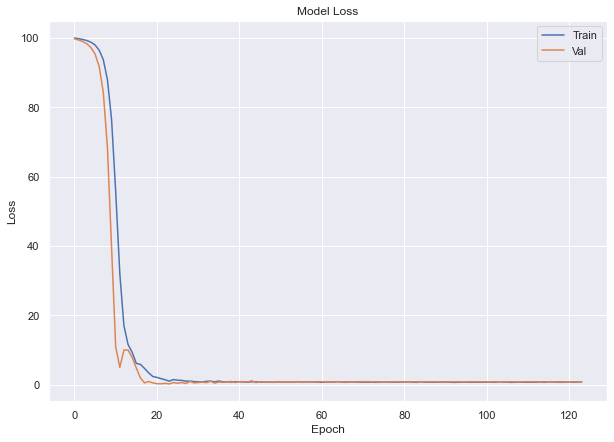

In [213]:
# Loss History
fig = plt.figure(figsize=(10, 7))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Previsão Multistep 12 meses
Para ficar adequado à realidade, não podemos usar os dados de 2022 para prever 2022. Portanto, a previsão de 2022 será feita do moto *multistep*, isto é, o mês de janeiro/2022 será previsto usando-se os dados de arrecadação de janeiro a dezembro de 2021; o mês de fevereiro/2022 será previsto usando-se os dados de fevereiro a dezembro de 2021 mais a previsão feita para o mês de janeiro/2022; o mês de março/2022 será previsto usando-se os dados de março a dezembro de 2021 mais os meses de janeiro e fevereiro de 2022 previstos nos passos anteriores. E assim por diante, até que a previsão de dezembro/2022 será feita usando-se os dados de dezembro de 2021 mais as previsões de janeiro a novembro de 2022 feitas nos passos anteriores.

#### Remove os 12 últimos valores que serão previstos e cria as séries novamente

In [214]:
# remove
serie_multi1 = l_icms_ts[:-12]
print(l_icms_ts.shape)
print(serie_multi1.shape)

(144,)
(132,)


In [215]:
for i in range(12):
    # cria as séries
    X_multi1, Y_multi1 = cria_features_target(serie_multi1, verbose=0)

    # Faz a normalização usando o modelo fitado na normalização anterior
    X_multi_std1 = enc_x.transform(X_multi1)
    X_multi_std1 = X_multi_std1.reshape(X_multi_std1.shape[0],10,1)

    # Faz o janelamento das séries
    x_multi1, y_multi1 = janelamento_1_mes(X_multi_std1, Y_multi1, verbose=0)

    # Faz a predição da arrecadação do mês
    #y_pred_multi = np.mean(model.predict(x_multi[-1:]), axis=1)#[:,0].ravel()
    y_pred_multi1 = model.predict(x_multi1[-1:])#[:,0].ravel()
    print(i, np.exp(y_pred_multi1))

    #### Adicionar o valor previsto à série e fazer o novo janelamento
    serie_multi1 = pd.Series(np.append(serie_multi1, y_pred_multi1))

0 [[9.736851e+09]]
1 [[9.73518e+09]]
2 [[9.775202e+09]]
3 [[9.745882e+09]]
4 [[9.731524e+09]]
5 [[9.734028e+09]]
6 [[9.70896e+09]]
7 [[9.717334e+09]]
8 [[9.708739e+09]]
9 [[9.705868e+09]]
10 [[9.709997e+09]]
11 [[9.709534e+09]]


In [216]:
Y_pred_multi1 = np.exp(pd.Series(serie_multi1[-12:]))
Y_pred_multi1.index = icms_ts.index[-12:]

In [217]:
RMSE_lstm_multi1 = mean_squared_error(np.exp(y_test1), Y_pred_multi1, squared=False)
RMSE_lstm_multi1

547369645.5855662

In [218]:
MAPE_lstm_multi1 = mean_absolute_percentage_error(np.exp(y_test1), Y_pred_multi1)
MAPE_lstm_multi1

0.031794613331582726

In [219]:
previsoes['nome'].append('RNN-LSTM-1-mês')
previsoes['modelo'].append(model)
previsoes['previsoes'].append(Y_pred_multi1)

previsoes['rmse'].append(RMSE_lstm_multi1)

previsoes['mape'].append(MAPE_lstm_multi1)

previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(Y_pred_multi1
                                                        , np.exp(y_test1))])

### Modelo 12 meses

#### Criando as janelas de 12 meses e reshape para LSTM. A arrecadação de cada mês será prevista pela arrecadação dos 12 meses anteriores.

##### Unindo novamente os dados.

In [220]:
def janelamento_12_meses(X, Y, verbose=0):
    X_exp = np.concatenate((np.roll(X, 12, axis=0),
                            np.roll(X, 11, axis=0),
                            np.roll(X, 10, axis=0),
                            np.roll(X, 9, axis=0),
                            np.roll(X, 8, axis=0),
                            np.roll(X, 7, axis=0),
                            np.roll(X, 6, axis=0),
                            np.roll(X, 5, axis=0),
                            np.roll(X, 4, axis=0),
                            np.roll(X, 3, axis=0),
                            np.roll(X, 2, axis=0),
                            np.roll(X, 1, axis=0),
                            ), axis=2)
    X_exp_cut = X_exp[12:,:,:].transpose(0,2,1)
    Y_cut = Y[12:]
    if verbose==1:
        print('shape das features janeladas:', X_exp.shape)
        print('shape das features janeladas pós poda e transposição:', X_exp_cut.shape)
        print('shape do array target pós poda:', Y_cut.shape)
    return X_exp_cut, Y_cut

In [221]:
X_data_exp_cut12, Y_data_cut12 = janelamento_12_meses(X_data_jn, Y_data, verbose=0)

In [222]:
#Y_data_cut[0]

In [223]:
#X_data_exp_cut[0]

In [224]:
#Y_data_cut[Y_data_cut.shape[0]-1]

In [225]:
#X_data_exp_cut[Y_data_cut.shape[0]-1]

#### Separando novamente em treino, validação e teste

In [226]:
x_train12 = X_data_exp_cut12[:-24]
x_val12 = X_data_exp_cut12[-24:-12]
x_test12 = X_data_exp_cut12[-12:]
print(x_train12.shape, x_val12.shape, x_test12.shape)
y_train12 = Y_data_cut12[:-24]
y_val12 = Y_data_cut12[-24:-12]
y_test12 = np.exp(Y_data_cut12[-12:]) # tirar o log para ficar o valor real
print(y_train12.shape, y_val12.shape, y_test12.shape)

(96, 12, 10) (12, 12, 10) (12, 12, 10)
(96,) (12,) (12,)


### Criando o modelo LSTM

In [227]:
rlrop2 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=25, verbose=1)
early_stop2 = EarlyStopping(monitor='val_loss', patience=100, verbose=1, 
                           restore_best_weights=True)

#### Arquitetura da Rede

In [228]:
# Épocas e tamanho do lote
EPOCHS2 = 1000
BATCH2 = 8
NEURONIOS2 = 600
LR2 = 1e-5
DROPOUT2 = 0.25

# Imstanciação do modelo
model2 = Sequential()

# Adicionar camada LSTM 
model2.add(LSTM(activation='tanh', dropout=DROPOUT2,
        input_shape = (12, 10), return_sequences = True,
        units = NEURONIOS2))

# Adicionar camada LSTM 
model2.add(LSTM(activation='tanh', dropout=DROPOUT2,
        input_shape = (12, 10), return_sequences = True,
        units = NEURONIOS2))

## Adicionar camada LSTM 
model2.add(LSTM(activation='tanh', dropout=DROPOUT2,
        input_shape = (12, 10), return_sequences = False,
        units = NEURONIOS2))


# Adicionar a camada de saída com 1 neurônio linear
model2.add(Dense(
        units = 1,
        activation = 'linear'))
# a learning rate padrão do Adam é 0.001
model2.compile(loss = 'mape', optimizer = Adam(learning_rate=LR2))

In [229]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 12, 600)           1466400   
_________________________________________________________________
lstm_4 (LSTM)                (None, 12, 600)           2882400   
_________________________________________________________________
lstm_5 (LSTM)                (None, 600)               2882400   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 601       
Total params: 7,231,801
Trainable params: 7,231,801
Non-trainable params: 0
_________________________________________________________________


In [230]:
# History object for plotting our model loss by epoch
history2 = model2.fit(x_train12, y_train12, batch_size = BATCH2, 
                    epochs = EPOCHS2, validation_data = (x_val12, y_val12),
                    callbacks = [rlrop2, early_stop2])

Epoch 1/1000
12/12 [==============================] - 2s 170ms/step - loss: 99.8121 - val_loss: 99.1393
Epoch 2/1000
12/12 [==============================] - 1s 99ms/step - loss: 99.2672 - val_loss: 98.0524
Epoch 3/1000
12/12 [==============================] - 1s 104ms/step - loss: 98.6195 - val_loss: 96.6351
Epoch 4/1000
12/12 [==============================] - 1s 105ms/step - loss: 97.7175 - val_loss: 94.5781
Epoch 5/1000
12/12 [==============================] - 1s 117ms/step - loss: 96.3258 - val_loss: 91.2580
Epoch 6/1000
12/12 [==============================] - 2s 134ms/step - loss: 94.1532 - val_loss: 85.3241
Epoch 7/1000
12/12 [==============================] - 1s 118ms/step - loss: 90.0563 - val_loss: 74.6302
Epoch 8/1000
12/12 [==============================] - 1s 123ms/step - loss: 82.5848 - val_loss: 56.1634
Epoch 9/1000
12/12 [==============================] - 2s 129ms/step - loss: 69.0807 - val_loss: 33.0665
Epoch 10/1000
12/12 [==============================] - 1s 125ms/s

12/12 [==============================] - 1s 115ms/step - loss: 0.7762 - val_loss: 0.5923
Epoch 78/1000
12/12 [==============================] - 1s 109ms/step - loss: 0.7514 - val_loss: 0.5960
Epoch 79/1000
12/12 [==============================] - 1s 112ms/step - loss: 0.7740 - val_loss: 0.5978
Epoch 80/1000
12/12 [==============================] - 1s 116ms/step - loss: 0.7234 - val_loss: 0.5979
Epoch 81/1000
12/12 [==============================] - 1s 110ms/step - loss: 0.7104 - val_loss: 0.5964
Epoch 82/1000
12/12 [==============================] - 1s 110ms/step - loss: 0.7744 - val_loss: 0.5944
Epoch 83/1000
12/12 [==============================] - 1s 111ms/step - loss: 0.7293 - val_loss: 0.5934
Epoch 84/1000
12/12 [==============================] - 1s 114ms/step - loss: 0.8720 - val_loss: 0.5912
Epoch 85/1000
12/12 [==============================] - 1s 111ms/step - loss: 0.6715 - val_loss: 0.5868
Epoch 86/1000
12/12 [==============================] - 1s 111ms/step - loss: 0.7425 - v

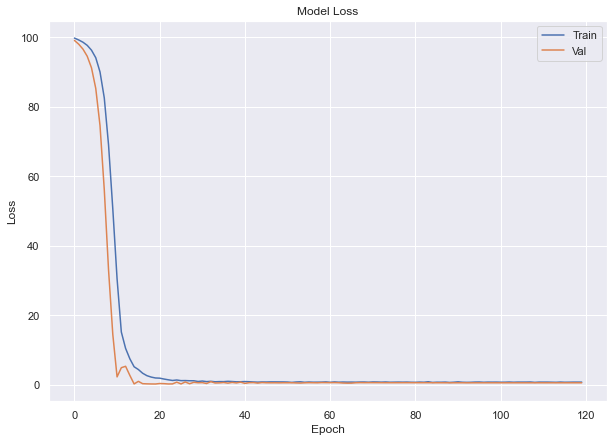

In [231]:
# Loss History
fig = plt.figure(figsize=(10, 7))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Previsão Multistep 12 meses
Para ficar adequado à realidade, não podemos usar os dados de 2022 para prever 2022. Portanto, a previsão de 2022 será feita do moto *multistep*, isto é, o mês de janeiro/2022 será previsto usando-se os dados de arrecadação de janeiro a dezembro de 2021; o mês de fevereiro/2022 será previsto usando-se os dados de fevereiro a dezembro de 2021 mais a previsão feita para o mês de janeiro/2022; o mês de março/2022 será previsto usando-se os dados de março a dezembro de 2021 mais os meses de janeiro e fevereiro de 2022 previstos nos passos anteriores. E assim por diante, até que a previsão de dezembro/2022 será feita usando-se os dados de dezembro de 2021 mais as previsões de janeiro a novembro de 2022 feitas nos passos anteriores.

#### Remove os 12 últimos valores que serão previstos e cria as séries novamente

In [232]:
# remove
serie_multi12 = l_icms_ts[:-12]
print(l_icms_ts.shape)
print(serie_multi12.shape)
type(serie_multi12)

(144,)
(132,)


pandas.core.series.Series

In [233]:
for i in range(12):
    # cria as séries
    X_multi12, Y_multi12 = cria_features_target(serie_multi12, verbose=0)

    # Faz a normalização usando o modelo fitado na normalização anterior
    X_multi_std12 = enc_x.transform(X_multi12)
    X_multi_std12 = X_multi_std12.reshape(X_multi_std12.shape[0],10,1)

    # Faz o janelamento das séries
    x_multi12, y_multi12 = janelamento_12_meses(X_multi_std12, Y_multi12, verbose=0)

    # Faz a predição da arrecadação do mês
    #y_pred_multi = np.mean(model.predict(x_multi[-1:]), axis=1)#[:,0].ravel()
    y_pred_multi12 = model2.predict(x_multi12[-1:])#[:,0].ravel()
    print(i, np.exp(y_pred_multi12))

    #### Adicionar o valor previsto à série e fazer o novo janelamento
    serie_multi12 = pd.Series(np.append(serie_multi12, y_pred_multi12))
    type(serie_multi12)

0 [[9.454991e+09]]
1 [[9.454305e+09]]
2 [[9.454611e+09]]
3 [[9.45914e+09]]
4 [[9.466575e+09]]
5 [[9.4725e+09]]
6 [[9.481503e+09]]
7 [[9.486476e+09]]
8 [[9.496687e+09]]
9 [[9.504588e+09]]
10 [[9.511642e+09]]
11 [[9.512839e+09]]


In [234]:
Y_pred_multi12 = np.exp(pd.Series(serie_multi12[-12:])) # tira o log das previsões
Y_pred_multi12.index = l_icms_ts.index[-12:]

In [235]:
Y_pred_multi12

date
2014-01-01    9.454991e+09
2014-02-01    9.454306e+09
2014-03-01    9.454612e+09
2014-04-01    9.459140e+09
2014-05-01    9.466576e+09
2014-06-01    9.472500e+09
2014-07-01    9.481502e+09
2014-08-01    9.486476e+09
2014-09-01    9.496687e+09
2014-10-01    9.504588e+09
2014-11-01    9.511642e+09
2014-12-01    9.512840e+09
dtype: float64

In [236]:
Y_pred_multi12

date
2014-01-01    9.454991e+09
2014-02-01    9.454306e+09
2014-03-01    9.454612e+09
2014-04-01    9.459140e+09
2014-05-01    9.466576e+09
2014-06-01    9.472500e+09
2014-07-01    9.481502e+09
2014-08-01    9.486476e+09
2014-09-01    9.496687e+09
2014-10-01    9.504588e+09
2014-11-01    9.511642e+09
2014-12-01    9.512840e+09
dtype: float64

In [237]:
RMSE_lstm_multi12 = mean_squared_error(y_test12, Y_pred_multi12, squared=False)
RMSE_lstm_multi12

654956168.2167875

In [238]:
MAPE_lstm_multi12 = mean_absolute_percentage_error(y_test12, Y_pred_multi12)
MAPE_lstm_multi12

0.041914104189900124

In [239]:
previsoes['nome'].append('RNN-LSTM-12-meses')
previsoes['modelo'].append(model2)
previsoes['previsoes'].append(Y_pred_multi12)

previsoes['rmse'].append(RMSE_lstm_multi12)

previsoes['mape'].append(MAPE_lstm_multi12)

In [240]:
previsoes['erro relativo'].append([erro_relativo(prev,real) 
                                   for prev,real in zip(Y_pred_multi12
                                                        , y_test12)])

In [241]:
previsoes['nome']

['Mean',
 'SARIMA(0,1,1),(1,0,1)',
 'SARIMAX(0,1,1),(1,0,1)',
 'Markov-Fixed',
 'Markov-Switching-Var',
 'Markov-Mean-Var',
 'RNN-LSTM-1-mês',
 'RNN-LSTM-12-meses']

## Resultados

In [242]:
df_prev = pd.DataFrame(data=previsoes['previsoes'], 
                       index=previsoes['nome']).transpose()
df_prev["real"] = icms_test
df_rmse = pd.DataFrame(data=previsoes['rmse'], 
                       index=previsoes['nome']).transpose()
df_mape = pd.DataFrame(data=previsoes['mape'], 
                       index=previsoes['nome']).transpose()
df_erro = pd.DataFrame(data=previsoes['erro relativo'], 
                       index=previsoes['nome']).transpose()

In [243]:
df_prev

,Mean,"SARIMA(0,1,1),(1,0,1)","SARIMAX(0,1,1),(1,0,1)",Markov-Fixed,Markov-Switching-Var,Markov-Mean-Var,RNN-LSTM-1-mês,RNN-LSTM-12-meses,real
2014-01-01,9.527815e+09,9.684208e+09,9.591251e+09,1.007163e+10,9.678321e+09,9.554910e+09,9.736852e+09,9.454991e+09,9.803278e+09
2014-02-01,9.527815e+09,9.439189e+09,9.398393e+09,9.652935e+09,9.395793e+09,9.133837e+09,9.735180e+09,9.454306e+09,9.687760e+09
2014-03-01,9.527815e+09,9.711438e+09,9.621435e+09,9.883833e+09,9.560822e+09,9.368052e+09,9.775203e+09,9.454612e+09,9.465054e+09
2014-04-01,9.527815e+09,1.016781e+10,1.014393e+10,1.029767e+10,1.005072e+10,9.777133e+09,9.745882e+09,9.459140e+09,9.635430e+09
2014-05-01,9.527815e+09,1.013695e+10,1.010048e+10,1.029120e+10,1.005418e+10,9.722660e+09,9.731523e+09,9.466576e+09,9.819079e+09
2014-06-01,9.527815e+09,1.009886e+10,9.936621e+09,1.043959e+10,1.014643e+10,9.839228e+09,9.734029e+09,9.472500e+09,9.677264e+09
2014-07-01,9.527815e+09,1.023866e+10,1.018630e+10,1.051623e+10,1.016212e+10,9.864376e+09,9.708960e+09,9.481502e+09,9.594590e+09
2014-08-01,9.527815e+09,1.039424e+10,1.027989e+10,1.069690e+10,1.038654e+10,1.005842e+10,9.717334e+09,9.486476e+09,9.500060e+09
2014-09-01,9.527815e+09,1.070670e+10,1.060862e+10,1.109071e+10,1.077967e+10,1.041893e+10,9.708738e+09,9.496687e+09,9.796970e+09
2014-10-01,9.527815e+09,1.088322e+10,1.076082e+10,1.125571e+10,1.094398e+10,1.058193e+10,9.705868e+09,9.504588e+09,1.063363e+10


In [244]:
df_erro

,Mean,"SARIMA(0,1,1),(1,0,1)","SARIMAX(0,1,1),(1,0,1)",Markov-Fixed,Markov-Switching-Var,Markov-Mean-Var,RNN-LSTM-1-mês,RNN-LSTM-12-meses
0,2.809906,1.214595,2.162825,2.737335,1.274650,2.533522,0.677597,3.552764
1,1.650999,2.565827,2.986938,0.359471,3.013775,5.717761,0.489485,2.409788
2,0.663084,2.603086,1.652197,4.424471,1.011801,1.024846,3.276777,0.110321
3,1.116860,5.525229,5.277353,6.872948,4.310026,1.470645,1.146311,1.829601
4,2.966306,3.237237,2.865858,4.808231,2.394363,0.981962,0.891696,3.589985
5,1.544332,4.356560,2.680059,7.877533,4.848152,1.673645,0.586577,2.115933
6,0.695961,6.712824,6.167170,9.605880,5.915151,2.811856,1.192026,1.178665
7,0.292163,9.412335,8.208675,12.598244,9.331324,5.877392,2.287082,0.142981
8,2.747326,9.285787,8.284753,13.205497,10.030665,6.348478,0.900608,3.065061
9,10.399205,2.347180,1.196111,5.850173,2.918554,0.486171,8.724777,10.617641


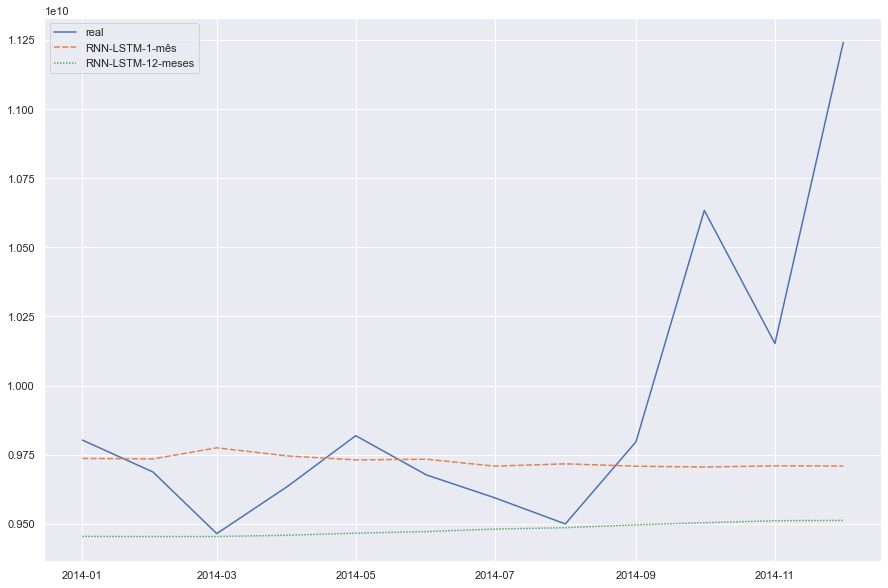

In [245]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=df_prev[['real', 'RNN-LSTM-1-mês', 'RNN-LSTM-12-meses']])

#### Previsões

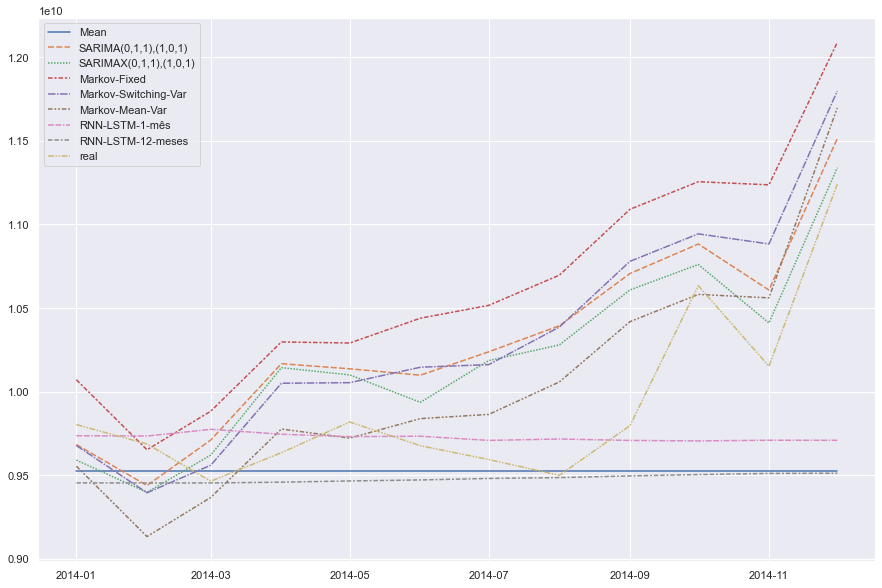

In [246]:
fig = plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=df_prev)

#### RMSE

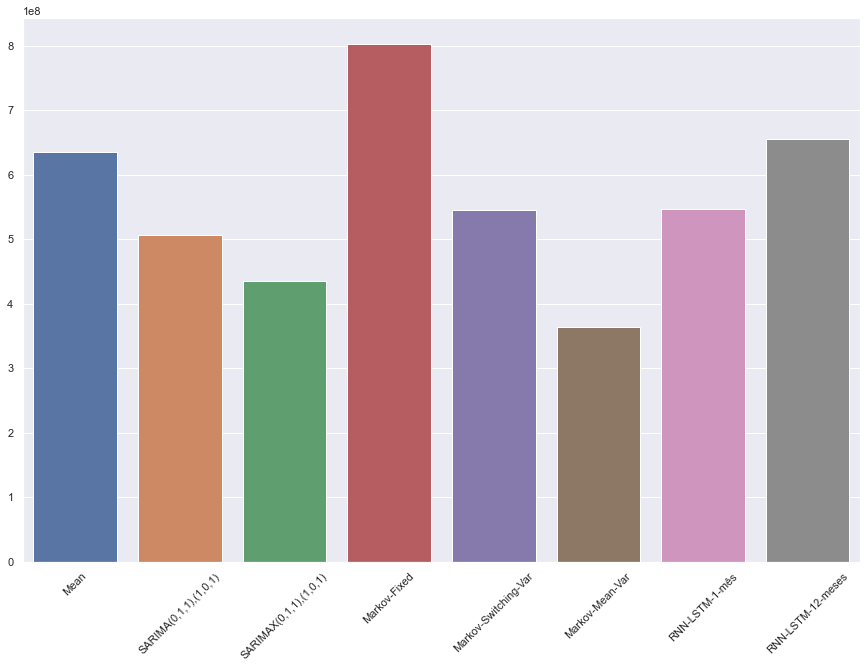

In [247]:
fig = plt.figure(figsize=(15, 10))
#df_rmse = df_rmse.drop(['mov_avg_12'], axis=1)
ax = sns.barplot(data=df_rmse)
_ = plt.xticks(rotation=45)

#### MAPE

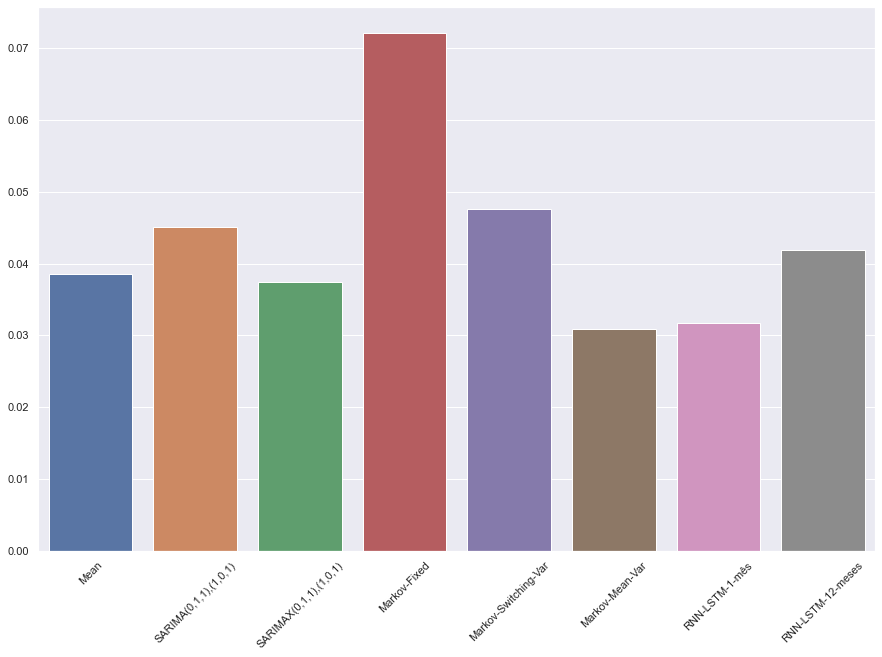

In [248]:
fig = plt.figure(figsize=(15, 10))
#df_mape = df_mape.drop(['mov_avg_12'], axis=1)
ax = sns.barplot(data=df_mape)
_ = plt.xticks(rotation=45)

### Resumo das métricas

In [249]:
df_rmse.index = ['RMSE']
df_mape.index = ['MAPE']

In [250]:
df_metricas = df_rmse.copy()
df_metricas = df_metricas.append(df_mape.copy())
df_metricas

,Mean,"SARIMA(0,1,1),(1,0,1)","SARIMAX(0,1,1),(1,0,1)",Markov-Fixed,Markov-Switching-Var,Markov-Mean-Var,RNN-LSTM-1-mês,RNN-LSTM-12-meses
RMSE,6.356890e+08,5.070562e+08,4.347452e+08,8.025424e+08,5.456377e+08,3.632138e+08,5.473696e+08,6.549562e+08
MAPE,3.856483e-02,4.514700e-02,3.742301e-02,7.213740e-02,4.767124e-02,3.084498e-02,3.179461e-02,4.191410e-02


In [251]:
print(df_metricas.transpose().to_latex())

\begin{tabular}{lrr}
\toprule
{} &          RMSE &      MAPE \\
\midrule
Mean                   &  6.356890e+08 &  0.038565 \\
SARIMA(0,1,1),(1,0,1)  &  5.070562e+08 &  0.045147 \\
SARIMAX(0,1,1),(1,0,1) &  4.347452e+08 &  0.037423 \\
Markov-Fixed           &  8.025424e+08 &  0.072137 \\
Markov-Switching-Var   &  5.456377e+08 &  0.047671 \\
Markov-Mean-Var        &  3.632138e+08 &  0.030845 \\
RNN-LSTM-1-mês         &  5.473696e+08 &  0.031795 \\
RNN-LSTM-12-meses      &  6.549562e+08 &  0.041914 \\
\bottomrule
\end{tabular}



In [252]:
print(df_prev['2014-01-01':'2014-04-01'].transpose().to_latex(escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &    2014-01-01 &    2014-02-01 &    2014-03-01 &    2014-04-01 \\
\midrule
Mean                   &  9.527815e+09 &  9.527815e+09 &  9.527815e+09 &  9.527815e+09 \\
SARIMA(0,1,1),(1,0,1)  &  9.684208e+09 &  9.439189e+09 &  9.711438e+09 &  1.016781e+10 \\
SARIMAX(0,1,1),(1,0,1) &  9.591251e+09 &  9.398393e+09 &  9.621435e+09 &  1.014393e+10 \\
Markov-Fixed           &  1.007163e+10 &  9.652935e+09 &  9.883833e+09 &  1.029767e+10 \\
Markov-Switching-Var   &  9.678321e+09 &  9.395793e+09 &  9.560822e+09 &  1.005072e+10 \\
Markov-Mean-Var        &  9.554910e+09 &  9.133837e+09 &  9.368052e+09 &  9.777133e+09 \\
RNN-LSTM-1-mês         &  9.736852e+09 &  9.735180e+09 &  9.775203e+09 &  9.745882e+09 \\
RNN-LSTM-12-meses      &  9.454991e+09 &  9.454306e+09 &  9.454612e+09 &  9.459140e+09 \\
real                   &  9.803278e+09 &  9.687760e+09 &  9.465054e+09 &  9.635430e+09 \\
\bottomrule
\end{tabular}



In [253]:
print(df_prev['2014-05-01':'2014-08-01'].transpose().to_latex(escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &    2014-05-01 &    2014-06-01 &    2014-07-01 &    2014-08-01 \\
\midrule
Mean                   &  9.527815e+09 &  9.527815e+09 &  9.527815e+09 &  9.527815e+09 \\
SARIMA(0,1,1),(1,0,1)  &  1.013695e+10 &  1.009886e+10 &  1.023866e+10 &  1.039424e+10 \\
SARIMAX(0,1,1),(1,0,1) &  1.010048e+10 &  9.936621e+09 &  1.018630e+10 &  1.027989e+10 \\
Markov-Fixed           &  1.029120e+10 &  1.043959e+10 &  1.051623e+10 &  1.069690e+10 \\
Markov-Switching-Var   &  1.005418e+10 &  1.014643e+10 &  1.016212e+10 &  1.038654e+10 \\
Markov-Mean-Var        &  9.722660e+09 &  9.839228e+09 &  9.864376e+09 &  1.005842e+10 \\
RNN-LSTM-1-mês         &  9.731523e+09 &  9.734029e+09 &  9.708960e+09 &  9.717334e+09 \\
RNN-LSTM-12-meses      &  9.466576e+09 &  9.472500e+09 &  9.481502e+09 &  9.486476e+09 \\
real                   &  9.819079e+09 &  9.677264e+09 &  9.594590e+09 &  9.500060e+09 \\
\bottomrule
\end{tabular}



In [254]:
print(df_prev['2014-09-01':'2014-12-01'].transpose().to_latex(escape=False))

\begin{tabular}{lrrrr}
\toprule
{} &    2014-09-01 &    2014-10-01 &    2014-11-01 &    2014-12-01 \\
\midrule
Mean                   &  9.527815e+09 &  9.527815e+09 &  9.527815e+09 &  9.527815e+09 \\
SARIMA(0,1,1),(1,0,1)  &  1.070670e+10 &  1.088322e+10 &  1.060820e+10 &  1.151359e+10 \\
SARIMAX(0,1,1),(1,0,1) &  1.060862e+10 &  1.076082e+10 &  1.041114e+10 &  1.133946e+10 \\
Markov-Fixed           &  1.109071e+10 &  1.125571e+10 &  1.123702e+10 &  1.208862e+10 \\
Markov-Switching-Var   &  1.077967e+10 &  1.094398e+10 &  1.088335e+10 &  1.179811e+10 \\
Markov-Mean-Var        &  1.041893e+10 &  1.058193e+10 &  1.056126e+10 &  1.169730e+10 \\
RNN-LSTM-1-mês         &  9.708738e+09 &  9.705868e+09 &  9.709997e+09 &  9.709534e+09 \\
RNN-LSTM-12-meses      &  9.496687e+09 &  9.504588e+09 &  9.511642e+09 &  9.512840e+09 \\
real                   &  9.796970e+09 &  1.063363e+10 &  1.015244e+10 &  1.124082e+10 \\
\bottomrule
\end{tabular}



In [255]:
df_metricas.transpose().to_excel('./metricas_uni_2014.xlsx', index_label='metrica')

In [256]:
df_prev.to_excel('./previsoes_uni_2014.xlsx', index_label='mes_ano')